# CARDIO CATCH DISEASES

## 0. INTRODUCTION

### 0.1 Planning

#### Input

-   Create a tool that increases the diagnostic accuracy;

-   Database with patient diagnoses;

#### Output

-   Model with stable accuracy for all situationsPerformance of the model;

-   Most important patient characteristics;

-   Tool that can be easy used by health specialists;

#### Tasks

1.  What information is important for predicting heart problems?
    -   Is blood pressure the most important parameter?


2.  Performance of the model:
    -   Can accuracy alone solve this problem?
    
    -   What is the minimum value required for a model used in health problems?


3.  Action Plan:
    -   User-friendly website to enter patient data and return forecast

### 0.2 Imports

In [89]:
import pickle
import numpy    as np
import pandas   as pd
import seaborn  as sns
import sweetviz as sv

from IPython.core.display       import HTML, Image
from typing                     import Union
from sklearn.model_selection    import train_test_split, KFold
from matplotlib                 import pyplot               as plt

from sklearn.preprocessing      import MinMaxScaler, RobustScaler

from sklearn.ensemble           import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier

from yellowbrick.features       import Rank1D
from boruta                     import BorutaPy

from xgboost                    import XGBClassifier
from lightgbm                   import LGBMClassifier
from catboost                   import CatBoostClassifier


from sklearn.feature_selection  import RFE
from sklearn.naive_bayes        import GaussianNB
from sklearn.metrics            import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model       import LogisticRegression
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.preprocessing      import MinMaxScaler, RobustScaler


### 0.3 Helper Functions

In [2]:
def numerical_metrics(numerical_attributes: Union[int, float]):
    """Shows the main values ​​for descriptive statistics in numerical variables.

    Args:
        numerical_attributes ([float64 and int64]): [Insert all numerical attributes in the dataset]

    Returns:
        [dataframe]: [A dataframe with mean, median, std deviation, skewness, kurtosis, min, max and range]
    """
    
    data_mean = pd.DataFrame(numerical_attributes.apply(np.mean)).T
    data_median = pd.DataFrame(numerical_attributes.apply(np.median)).T
    data_std = pd.DataFrame(numerical_attributes.apply(np.std)).T
    data_min = pd.DataFrame(numerical_attributes.apply(min)).T
    data_max = pd.DataFrame(numerical_attributes.apply(max)).T
    data_range = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
    data_q1 = pd.DataFrame(numerical_attributes.apply(lambda x: np.quantile(x, .25))).T
    data_q3 = pd.DataFrame(numerical_attributes.apply(lambda x: np.quantile(x, .75))).T
    data_skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
    data_kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

    num_attributes = pd.concat([data_min,data_max,data_range,data_mean,data_median, data_q1, data_q3,data_std,data_skew,data_kurtosis]).T.reset_index()
    num_attributes.columns = ['Attributes','Min','Max','Range','Mean','Median','Q1','Q3', 'St deviation','Skewness','Kurtosis']

    return num_attributes

In [3]:
def categorical_metrics(data: Union[int, str], col: str):
    """
    Shows the the absolute and percent values in categorical variables.

    Args:
        data ([dataframe]): [Insert all categorical attributes in the dataset]

    Returns:
        [dataframe]: [A dataframe with absolute and percent values]
    """
    
    return pd.DataFrame({'absolute': data[col].value_counts(), 'percent %': data[col].value_counts(normalize = True) * 100 })

In [4]:
def cat_convert(data: Union[int, float]):
     """
     Revert the Encoding on Categorical Features
 
     Args:
        data ([dataframe]): [Insert all categorical attributes in the dataset]

     Returns:
        data ([dataframe]): [Categorical Dataframe]
     """

     data['gender'] = data['gender'].apply(lambda x: 'woman' if x == 1 else 'man')
     
     data['smoker'] = data['smoker'].apply(lambda x: 'yes' if x == 1 else 'no') 
     
     data['alcohol_intake'] = data['alcohol_intake'].apply(lambda x: 'yes' if x == 1 else 'no')   
     
     data['physical_activity'] = data['physical_activity'].apply(lambda x: 'yes' if x == 1 else 'no')    
     
     data['cardio_result'] = data['cardio'].apply(lambda x: 'yes' if x == 1 else 'no') 
     
     data['cholesterol'] = data['cholesterol'].apply(lambda x: 'normal' if x == 1 else
                                                      'above normal' if x == 2 else
                                                      'well above normal')

     data['glucose'] = data['glucose'].apply(lambda x: 'normal' if x == 1 else
                                             'above normal' if x == 2 else
                                             'well above normal')

     return data    

In [5]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use('tableau-colorblind10')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    sns.set()

jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [6]:
def multiple_kdeplots(df: Union[int, float, str], rows: int, cols: int):
    """
    Shows a matrix with kdeplots of selected features.

    Args:
        df ([dataframe]): [Insert all categorical attributes in the dataset]
        rows ([int]): [Insert the number of rows of the subplot]
        cols ([int]): [Insert the number of columns of the subplot]

    Returns:
        [Image]: [A matrix plot with kdeplots]
    """

    for i, col in enumerate(df.columns, 1):
        plt.subplot(rows, cols, i)
        ax = sns.kdeplot(data = df, x = col)
        plt.ylabel('')

    return ax

In [7]:
def multiple_boxplots(df: Union[int, float, str], rows: int, cols: int):
    """
    Shows a matrix with boxplots of selected features.

    Args:
        df ([dataframe]): [Insert all categorical attributes in the dataset]
        rows ([int]): [Insert the number of rows of the subplot]
        cols ([int]): [Insert the number of columns of the subplot]

    Returns:
        [Image]: [A matrix plot with boxplots]
    """

    for i, col in enumerate(df.columns, 1):
        plt.subplot(rows, cols, i)
        ax = sns.boxplot(data = df, x = col)
        plt.ylabel('')

    return ax

In [ ]:
def metrics_df(models, target: str, X_train: Union[int, float, str], y_train: Union[int, float, str], X_val: Union[int, float, str], y_val: Union[int, float, str], verbose = True):
    """Return Metrics of the model
    
    Args:
        model: [ML model for metrics evaluation]
        target[str]: [Target feature name]
        X_train[dataframe]: [Train variables]
        y_train[list]: [Target feature list]
        X_val[dataframe]: [Validation variables]
        y_val[list]: [Target feature list]
        verbose[bool]: [print training]

    Returns:
        [DataFrame]: [Dataframe with metrics]
    """
    print('Please, wait a moment - Doing ML')
    model_df = []
    i = 1
    j = len(models)

    for model in models:
        model_name = type(model).__name__
        if verbose == True:
            print(f"Training model {i}/{j} -> " + model_name)
        model.fit(X_train, y_train)

        # probabilities prediction
        yhat = model.predict(X_val)

        # accuracy
        accuracy = accuracy_score(y_val, yhat)

        # precision
        precision = precision_score(y_val, yhat)

        # recall
        recall = recall_score(y_val, yhat)

        # f1 score
        f1 = f1_score(y_val, yhat)

        # roc auc
        roc_auc = roc_auc_score(y_val, yhat)

        i += 1

        df_result = pd.DataFrame({'Model_Name': model_name, 
                                  'Accuracy': accuracy,
                                  'Precision': precision,
                                  'Recall': recall,
                                  'F1-Score': f1,
                                  'ROCAUC': roc_auc}, index = [0])

        model_df.append(df_result)
        final_result = pd.concat(model_df)
    print('Finished, check the results')

    return final_result

In [87]:
def cross_validation(models, target: str, X_train: Union[int, float, str], y_train: Union[int, float, str], kfold: int = 5, verbose: bool = True):
    """Return CV result
    
    Args:
        model: [ML model for CV]
        target[str]: [Target feature name]
        X_train[dataframe]: [Train variables]
        y_train[list]: [Target feature list]
        kfold[int]: [Number of data splits]
        verbose[bool]: [print folding]

    Returns:
        [DataFrame]: [Dataframe for CV]
    """
    print('Please, wait a moment, Doing CV')
    folds = KFold(n_splits = kfold, shuffle = True, random_state = 42)
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    roc_auc_list = []

    model_df = []
    j = 1
    l = len(models)
    
    for model in models:
        model_name = type(model).__name__
        if verbose == True:
            print(f"Folding model {j}/{l} -> " + model_name)

        for train_cv, val_cv in folds.split(X_train, y_train):
            X_train_fold = X_train.iloc[train_cv]
            y_train_fold = y_train.iloc[train_cv]
            X_val_fold = X_train.iloc[val_cv]
            y_val_fold = y_train.iloc[val_cv]

            # fit model
            model.fit(X_train_fold, y_train_fold)
            
            # predict probabilities
            yhat = model.predict(X_val_fold)

            data = X_val_fold.copy()
            data[target] = y_val_fold.copy()

            # accuracy
            accuracy = accuracy_score(y_val_fold, yhat)
            accuracy_list.append(accuracy)

            # precision
            precision = precision_score(y_val_fold, yhat)
            precision_list.append(precision)

            # recall
            recall = recall_score(y_val_fold, yhat)
            recall_list.append(recall)

            # f1 score
            f1 = f1_score(y_val_fold, yhat)
            f1_list.append(f1)

            # roc auc
            roc_auc = roc_auc_score(y_val_fold, yhat)
            roc_auc_list.append(roc_auc)


        df_result = pd.DataFrame({'Model_Name': (model_name),
                                  'Accuracy Mean': np.mean(accuracy_list).round(3),
                                  'Accuracy STD': np.std(accuracy_list).round(3),
                                  'Precision Mean': np.mean(precision_list).round(3),
                                  'Precision STD': np.std(precision_list).round(3),
                                  'Recall Mean': np.mean(recall_list).round(3),
                                  'Recall STD': np.std(recall_list).round(3),
                                  'F1 Score Mean': np.mean(f1_list).round(3),
                                  'F1 Score STD': np.std(f1_list).round(3),
                                  'ROCAUC Mean': np.mean(roc_auc_list).round(3),
                                  'ROCAUC STD': np.std(roc_auc_list).round(3)}, index = [0])
        
        j += 1

        model_df.append(df_result)
        cv_result = pd.concat(model_df)
    print('Finished, check the results')

    return cv_result

### 0.4 Settings

In [8]:
# round
pd.options.display.float_format = '{:.3f}'.format

seed = 42

homepath = '/home/gutto/Repos/Cardio-Catch-Diseases/'

### 0.5 DATA

This dataset is avaliable [here](https://www.kaggle.com/sulianova/cardiovascular-disease-dataset).

There are 3 types of input features:

Objective: factual information;

Examination: results of medical examination;

Subjective: information given by the patient.


**Data fields**

-   **Age:** *Objective Feature* | Age in days
-   **Height:** *Objective Feature* | Height in cm
-   **Weight:** *Objective Feature* | Weight in kg
-   **Gender:** *Objective Feature* | Biological gender, can be Male or Female, 1- Woman, 2- Man
-   **Systolic blood pressure (ap_hi):** *Examination Feature*
-   **Diastolic blood pressure (ap_lo):** *Examination Feature*
-   **Cholesterol:** *Examination Feature* | Can be classified as 1: normal, 2: above normal, 3: well above normal
-   **Glucose:** *Examination Feature* | Can be classified as 1: normal, 2: above normal, 3: well above normal
-   **Smoking:** *Subjective Feature* | Can be smoke or binary
-   **Alcohol intake:** *Subjective Feature* | Can be alco or binary
-   **Physical activity:** *Subjective Feature* | Can be active or binary
-   **Presence or absence of cardiovascular disease:** *Target Variable* | Can be cardio or binary

In [9]:
df_raw = pd.read_csv(homepath + '/data/raw/cardio_train.csv', sep = ';')

df_raw.to_pickle(homepath + 'data/processed/df_raw.pkl')


## 1. DATA DESCRIPTION

### 1.1 Dataset First Look

In [10]:
df1 = pd.read_pickle(homepath + 'data/processed/df_raw.pkl')

In [11]:
df1.head().T

,0,1,2,3,4
id,0.000,1.000,2.000,3.000,4.000
age,18393.000,20228.000,18857.000,17623.000,17474.000
gender,2.000,1.000,1.000,2.000,1.000
height,168.000,156.000,165.000,169.000,156.000
weight,62.000,85.000,64.000,82.000,56.000
ap_hi,110.000,140.000,130.000,150.000,100.000
ap_lo,80.000,90.000,70.000,100.000,60.000
cholesterol,1.000,3.000,3.000,1.000,1.000
gluc,1.000,1.000,1.000,1.000,1.000
smoke,0.000,0.000,0.000,0.000,0.000


In [12]:
df1.rename(columns = {'gluc': 'glucose', 'alco': 'alcohol_intake', 'smoke': 'smoker', 'alco': 'alcohol_intake', 'active': 'physical_activity'}, inplace = True)

### 1.2 Data Dimensions

In [13]:
print(f'Number of rows: {df1.shape[0]} \nNumber of columns: {df1.shape[1]}')

Number of rows: 70000 
Number of columns: 13


### 1.3 Check Data

In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 70000 non-null  int64  
 1   age                70000 non-null  int64  
 2   gender             70000 non-null  int64  
 3   height             70000 non-null  int64  
 4   weight             70000 non-null  float64
 5   ap_hi              70000 non-null  int64  
 6   ap_lo              70000 non-null  int64  
 7   cholesterol        70000 non-null  int64  
 8   glucose            70000 non-null  int64  
 9   smoker             70000 non-null  int64  
 10  alcohol_intake     70000 non-null  int64  
 11  physical_activity  70000 non-null  int64  
 12  cardio             70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


### 1.4 Descriptive Statistics

#### 1.4.1 SweetViz Report

                                             |          | [  0%]   00:00 -> (? left)


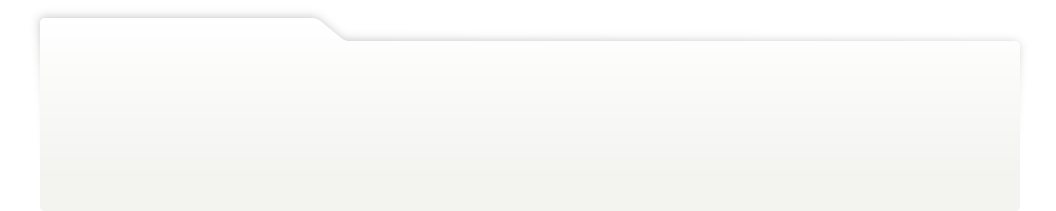
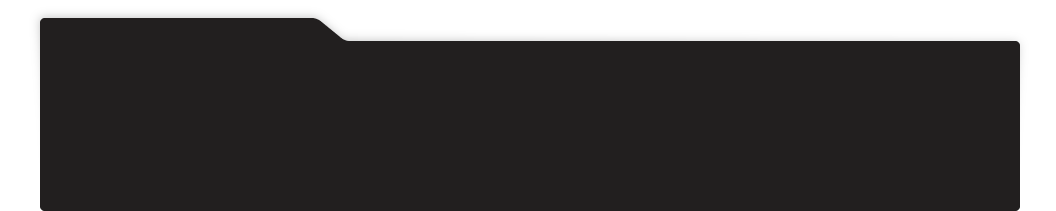
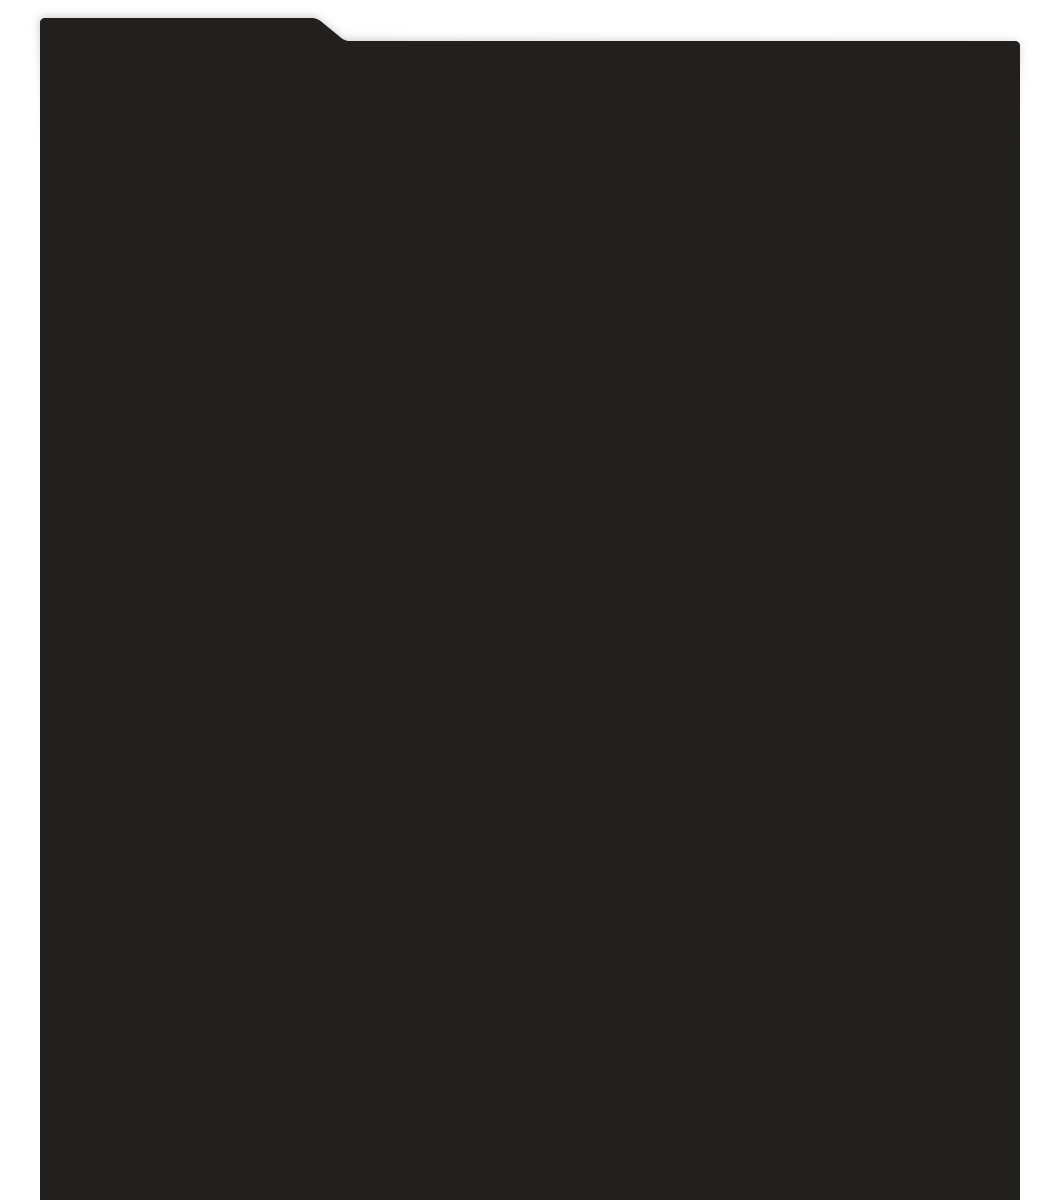
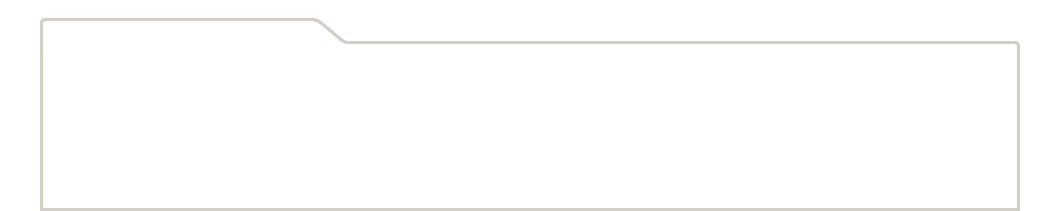
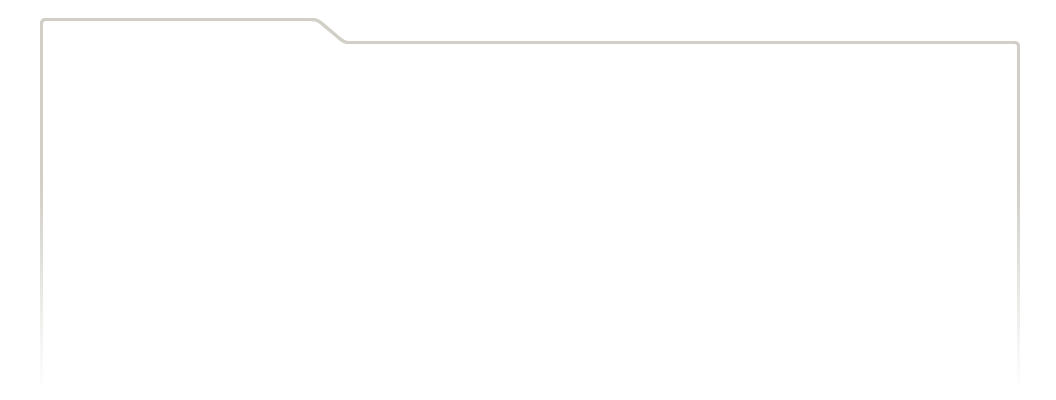
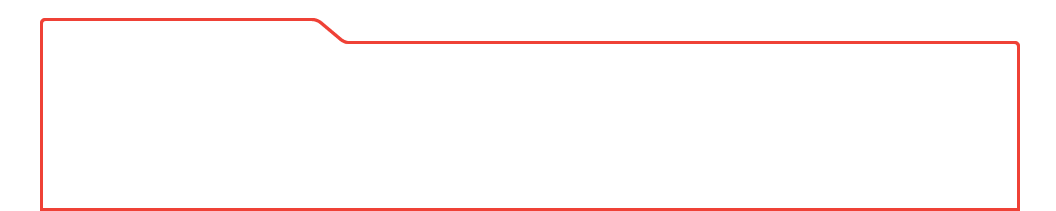
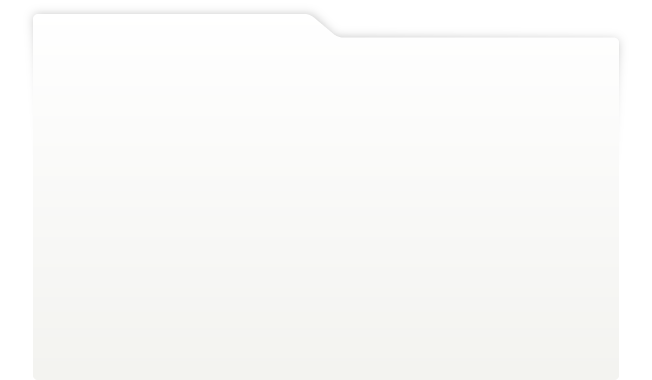
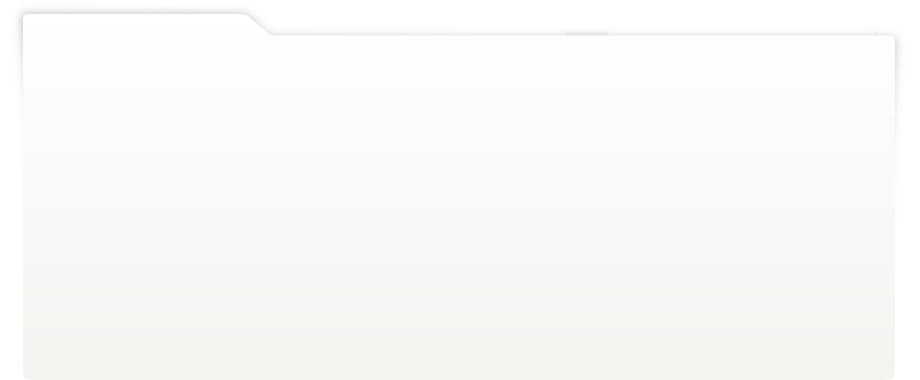
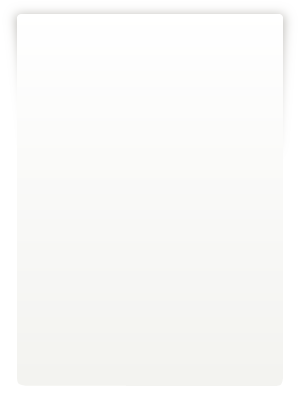
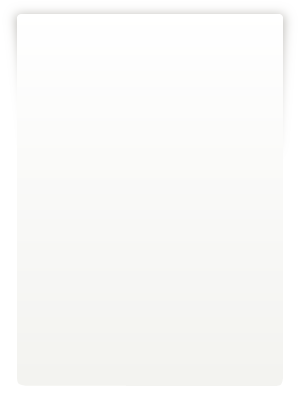
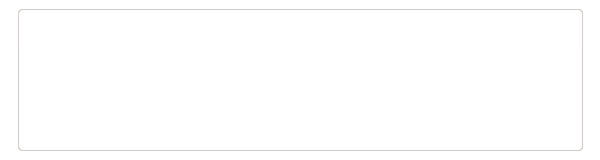
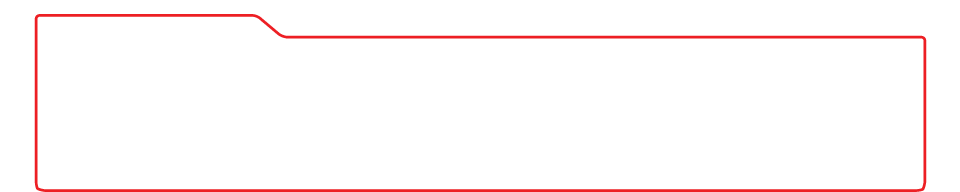
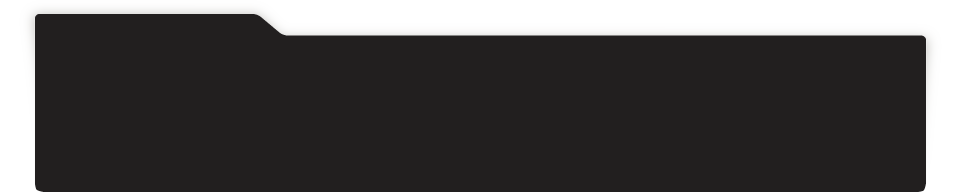
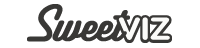
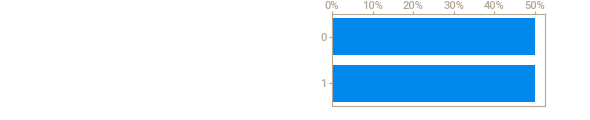
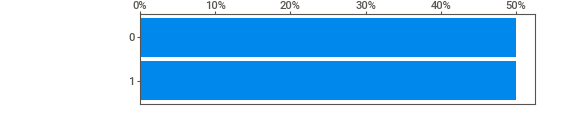
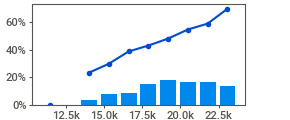
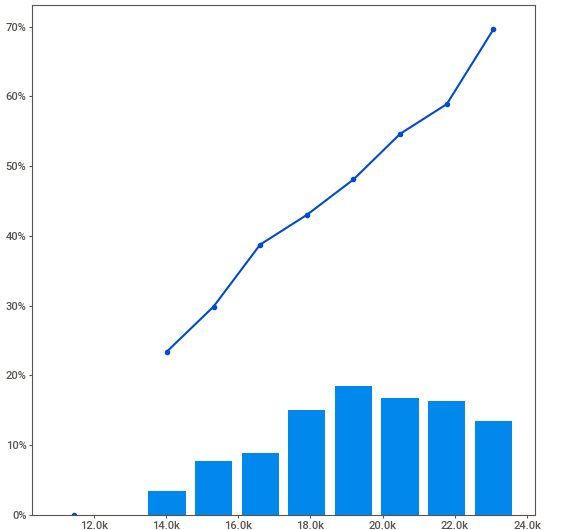
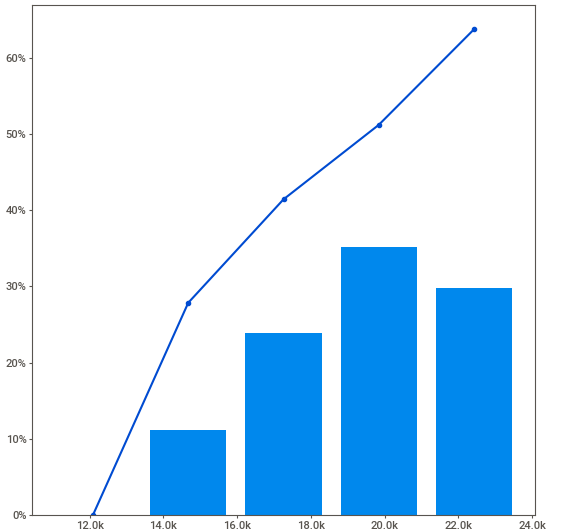
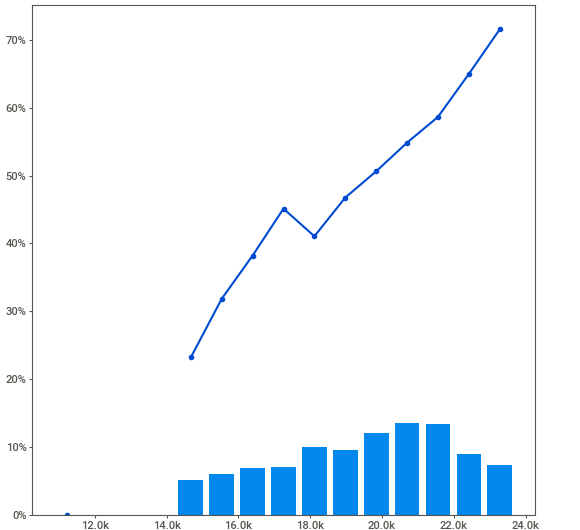
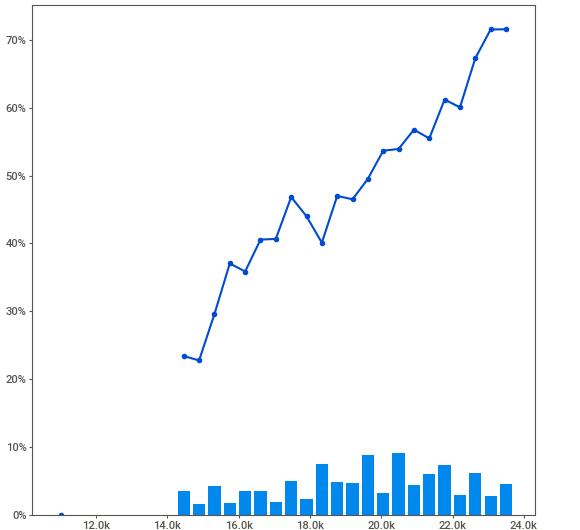
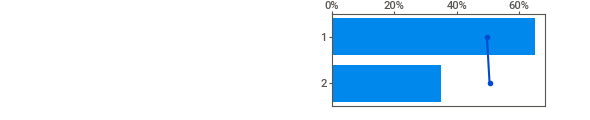
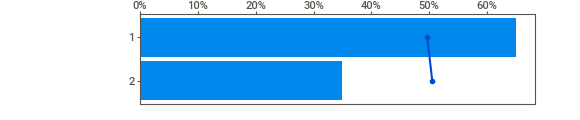
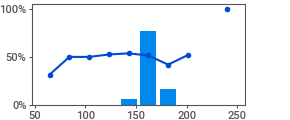
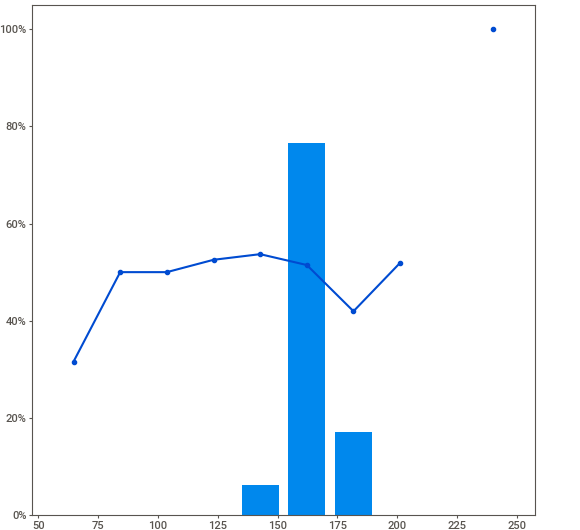
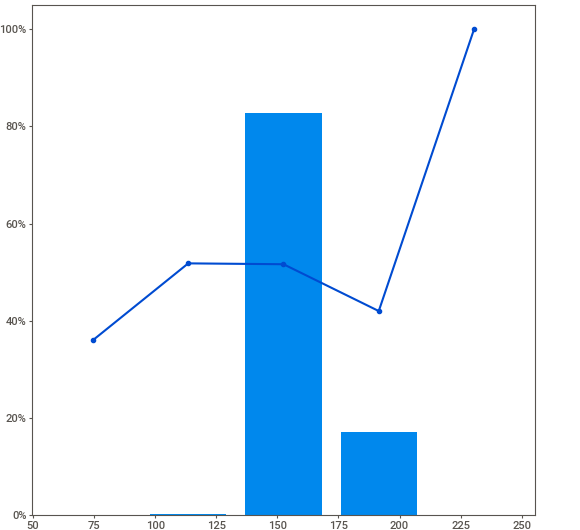
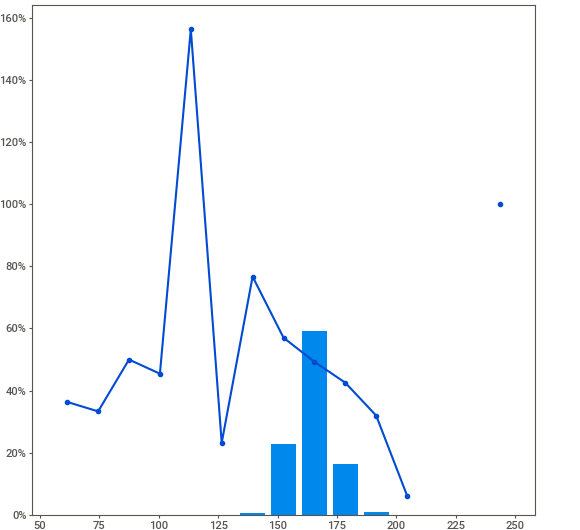
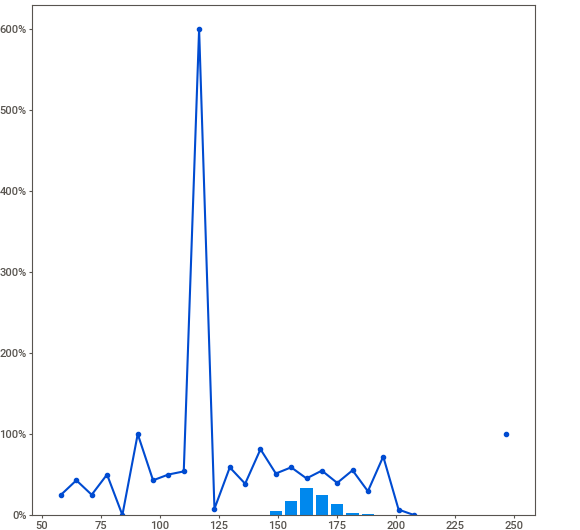
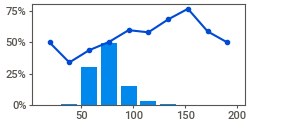
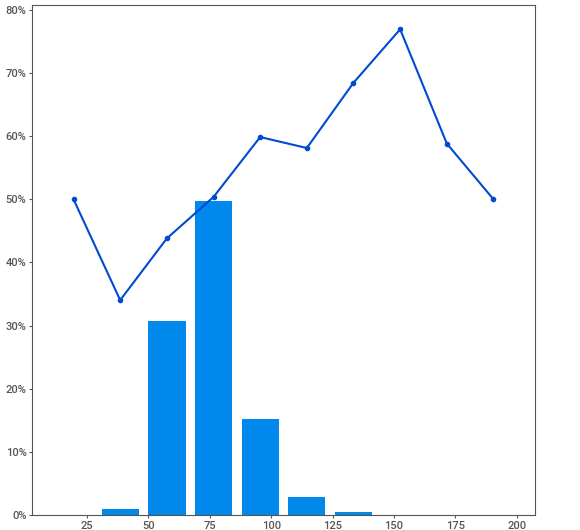
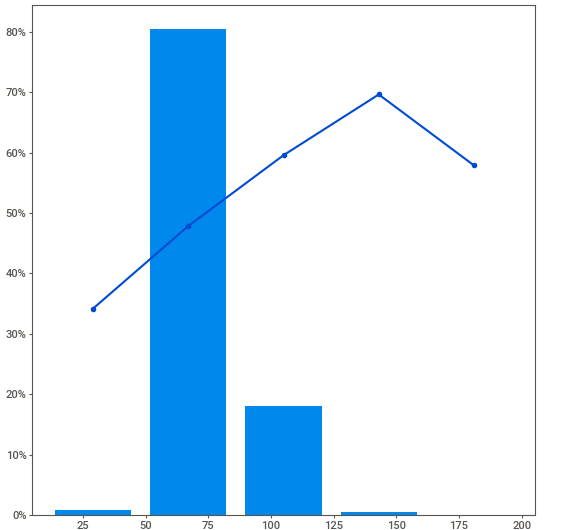
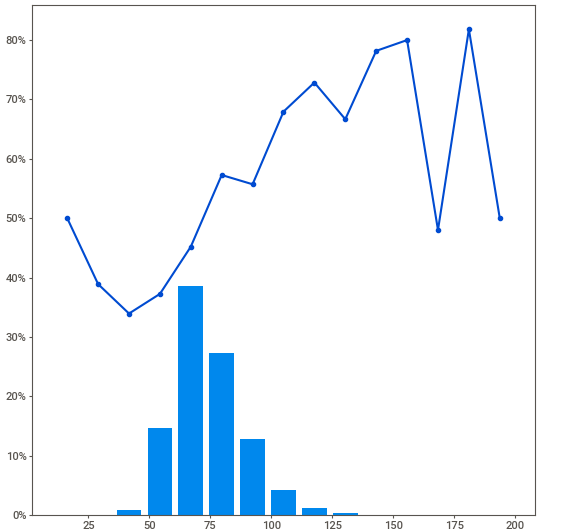
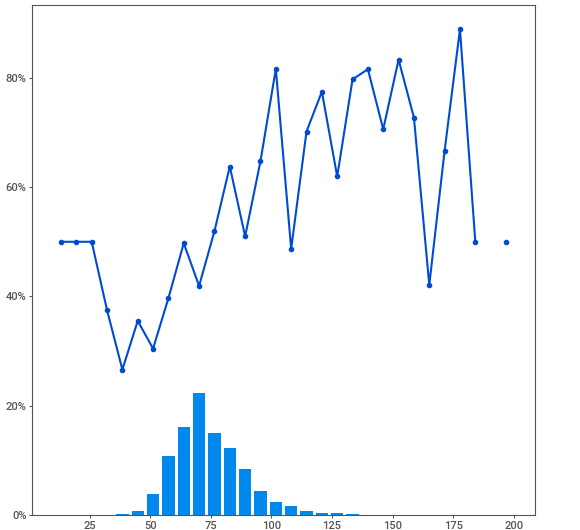
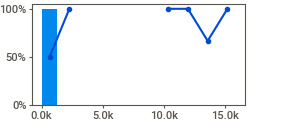
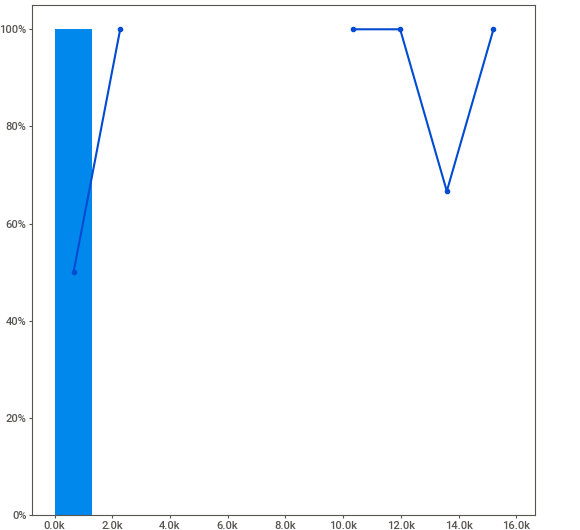
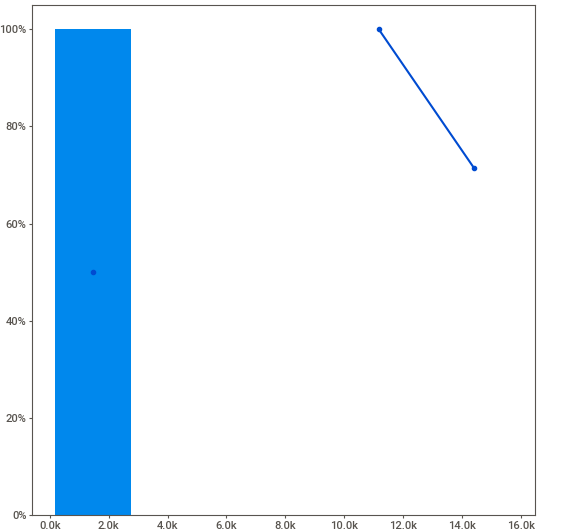
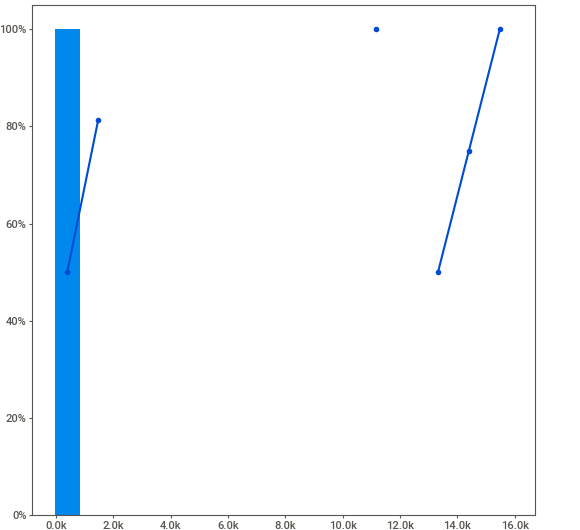
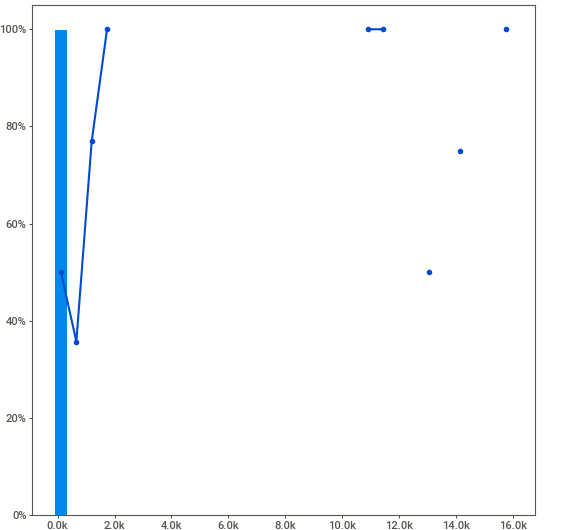
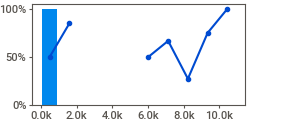
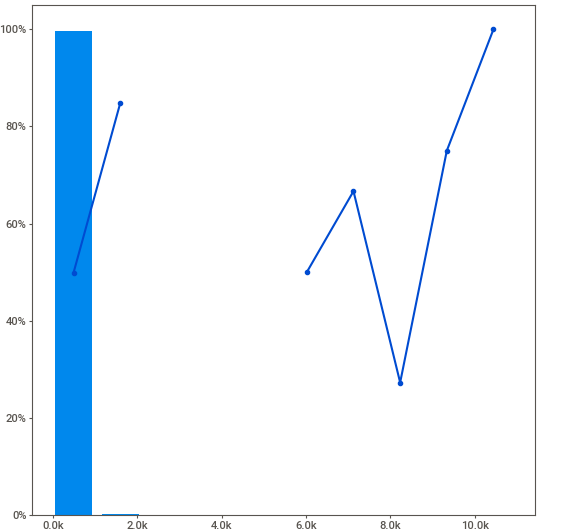
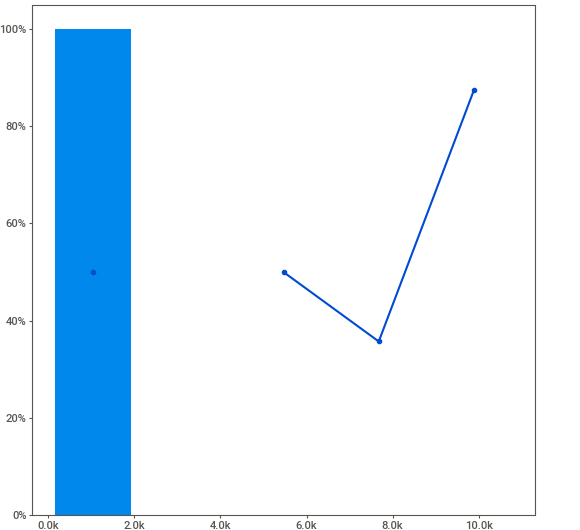
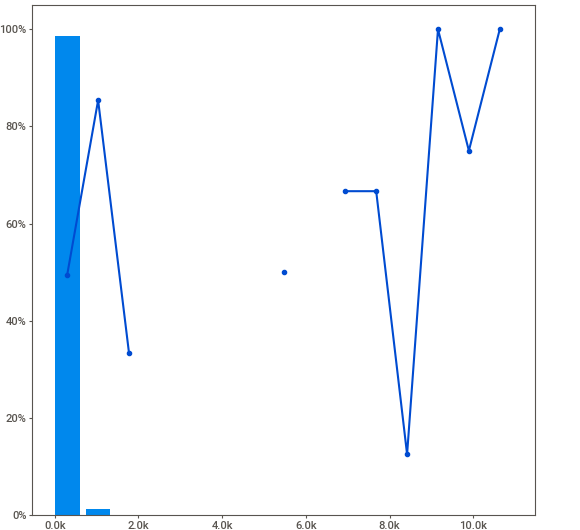
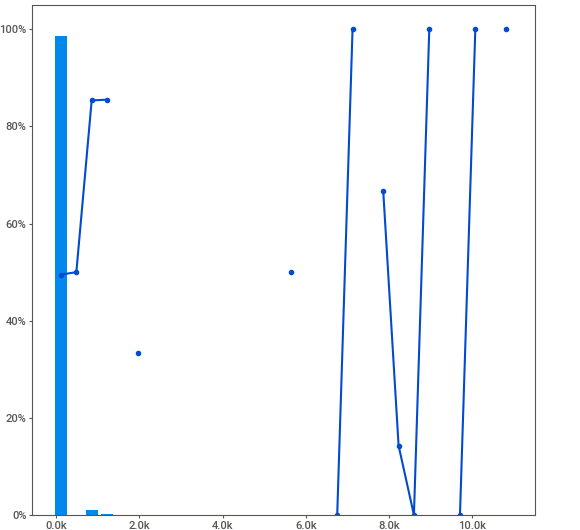
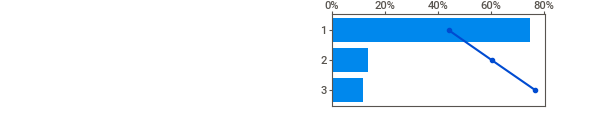
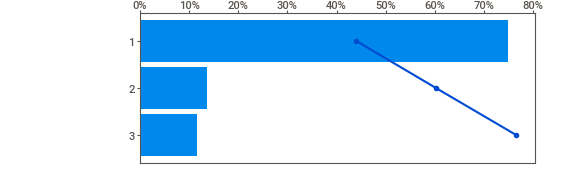
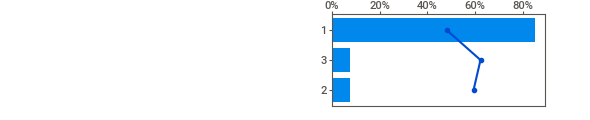
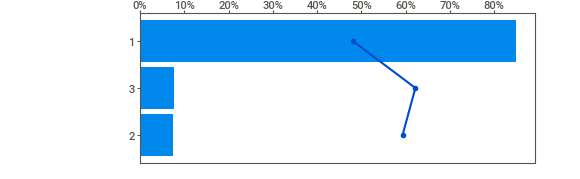
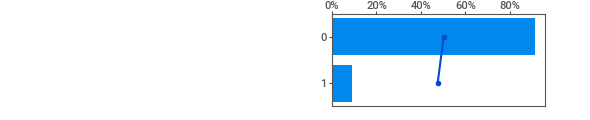
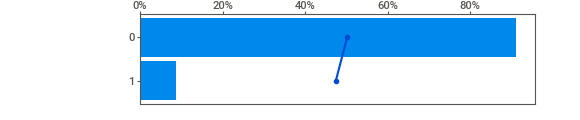
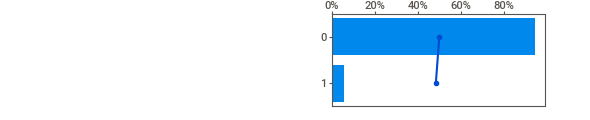
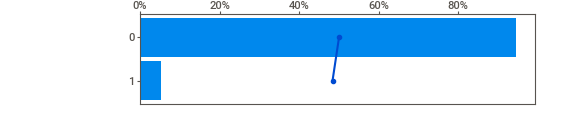
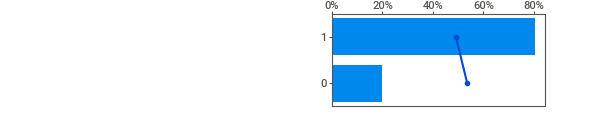
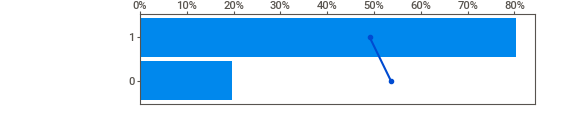
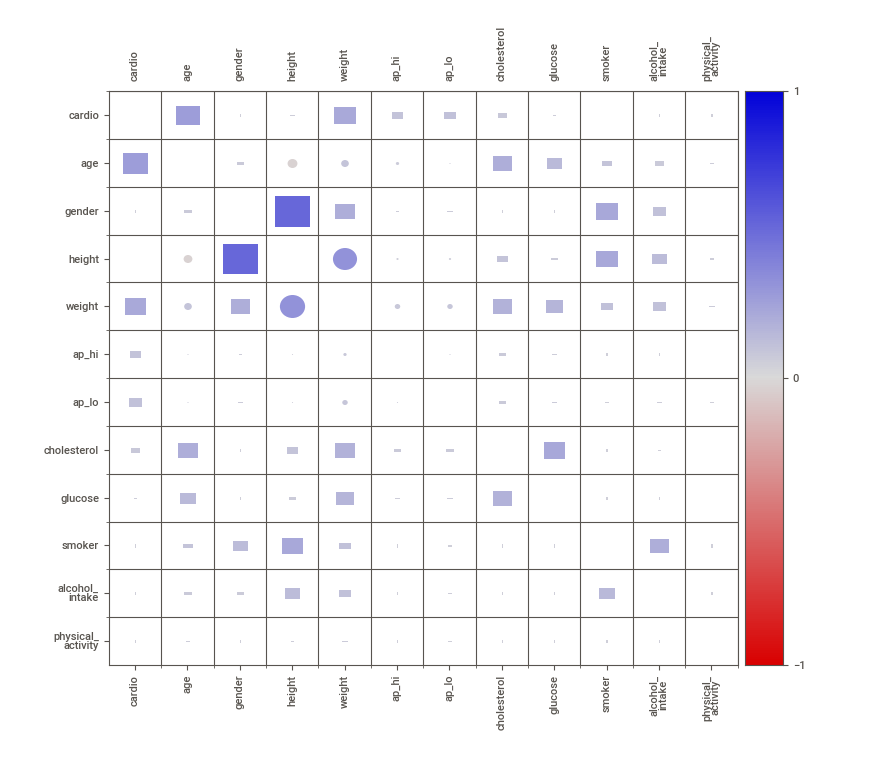
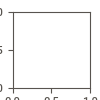

In [15]:
feature_config = sv.FeatureConfig(skip = 'id', force_cat = ['gender', 'cholesterol', 'glucose', 'smoker', 'alcohol_intake', 'physical_activity'])
report_1 = sv.analyze([df1, 'Cardio Catch Diseases'], 'cardio', feature_config)

report_1.show_notebook(layout = 'vertical', scale = 0.9)

**Report Insights**

*Target*

1. `cardio`
    - the feature is balanced (50/50);
    - highest correlation ratios is `age`(0.24) and `weight`(0.18);
    - `cholesterol` and `glucose` seems to be a little relevant to the target;

*Numerical Features*

2. `age`
    - should be in year, not days;
    - highest correlation ratios are `cardio`(0.24) and `glucose`(0.16);
    - negative skewed curve;
    - negative kurtosis(platykurtic);

3. `height`
    - should be in m, not cm;
    - highest correlation ratios are `weight`(0.29), `gender`(0.5) and `smoker`(0.19);
    - negative skewed curve;
    - positive kurtosis(leptokurtic);

4. `weight`
    - highest correlation ratios are `height`(0.29), `cardio`(0.18) and `gender`(0.16);
    - positive skewed curve;
    - positive kurtosis(leptokurtic);
    - Highest weight is 200kg and min 10 **need attention**;

5. `ap_hi` (systolic blood pressure)
    - no strong correlation to be cited;
    - positive skewed curve;
    - positive kurtosis(leptokurtic);
    - avg and median are ok;
    - Highest weight is 16020 and min -150 **need attention**;

6. `ap_lo` (diastolic blood pressure)    
    - no strong correlation to be cited;
    - positive skewed curve;
    - positive kurtosis(leptokurtic);
    - avg and median are ok;
    - Highest weight is 11000 and min -70 **need attention**;

*Categorical Features*

7. `gender`
    - unbalanced (65/35) but seems to be the normal in reality;
    - highest correlation ratios are `smoker`(0.19) and `height`(0.5);

8. `cholesterol`
    - unbalanced (75/14/12) but seems to be the normal in reality;
    - highest correlation ratios are `glucose`(0.19) and `age`(0.16);

9. `glucose`
    - unbalanced (85/8/7) but seems to be the normal in reality;
    - highest correlation ratios are `smoker`(0.14) and `height`(0.12);

10. `smoker`
    - unbalanced (91/9) but seems to be the normal in reality;
    - highest correlation ratios are `gender`(0.19), `smoker`(0.16) and `height`(0.19);

11. `alcohol_intake`
    - unbalanced (95/5) but seems to be the 'normal' in reality;
    - highest correlation ratios are `smoker`(0.16) and `height`(0.09);


12. `physical_activity`
    - unbalanced (80/20) but seems to be the normal in reality;
    - no strong correlation to be cited, this feature can be possibly dropped in the future steps;

#### 1.4.2 Numerical Attributes

In [16]:
num_attributes = df1[['age', 'height', 'weight', 'ap_hi', 'ap_lo']]

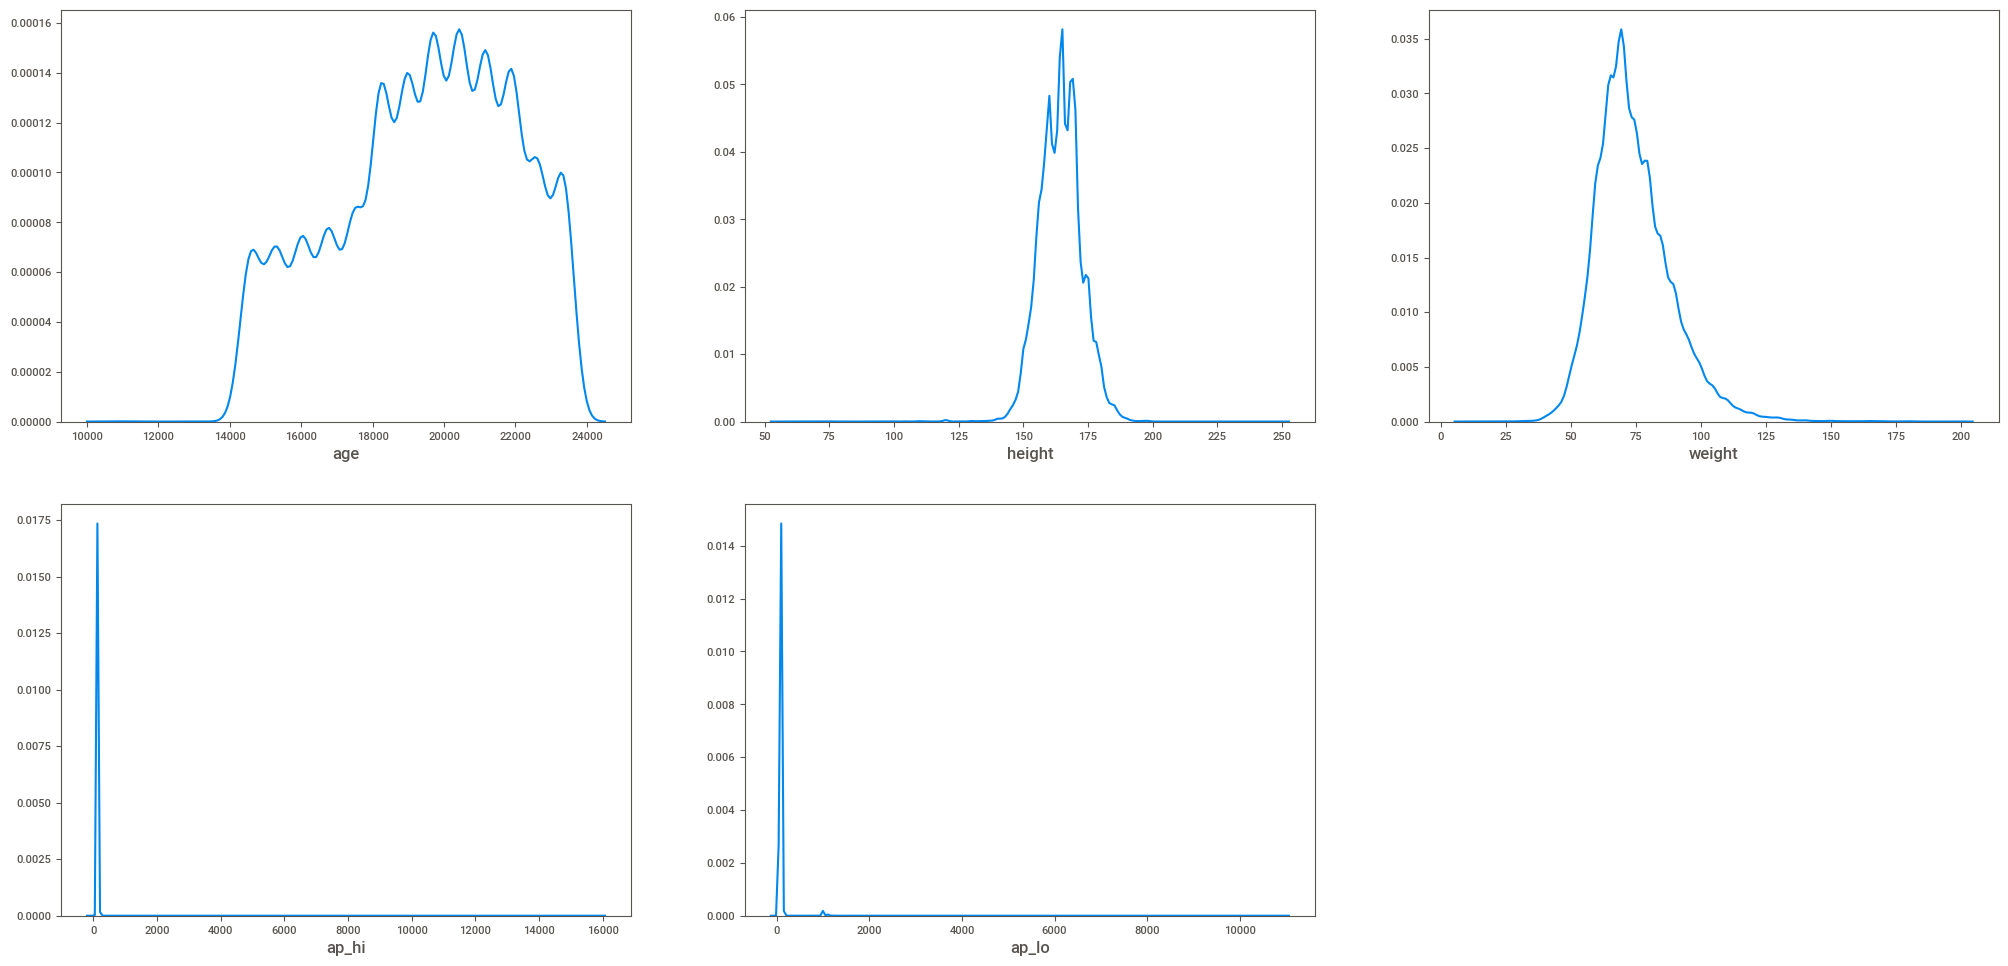

In [17]:
multiple_kdeplots(num_attributes, 2, 3);

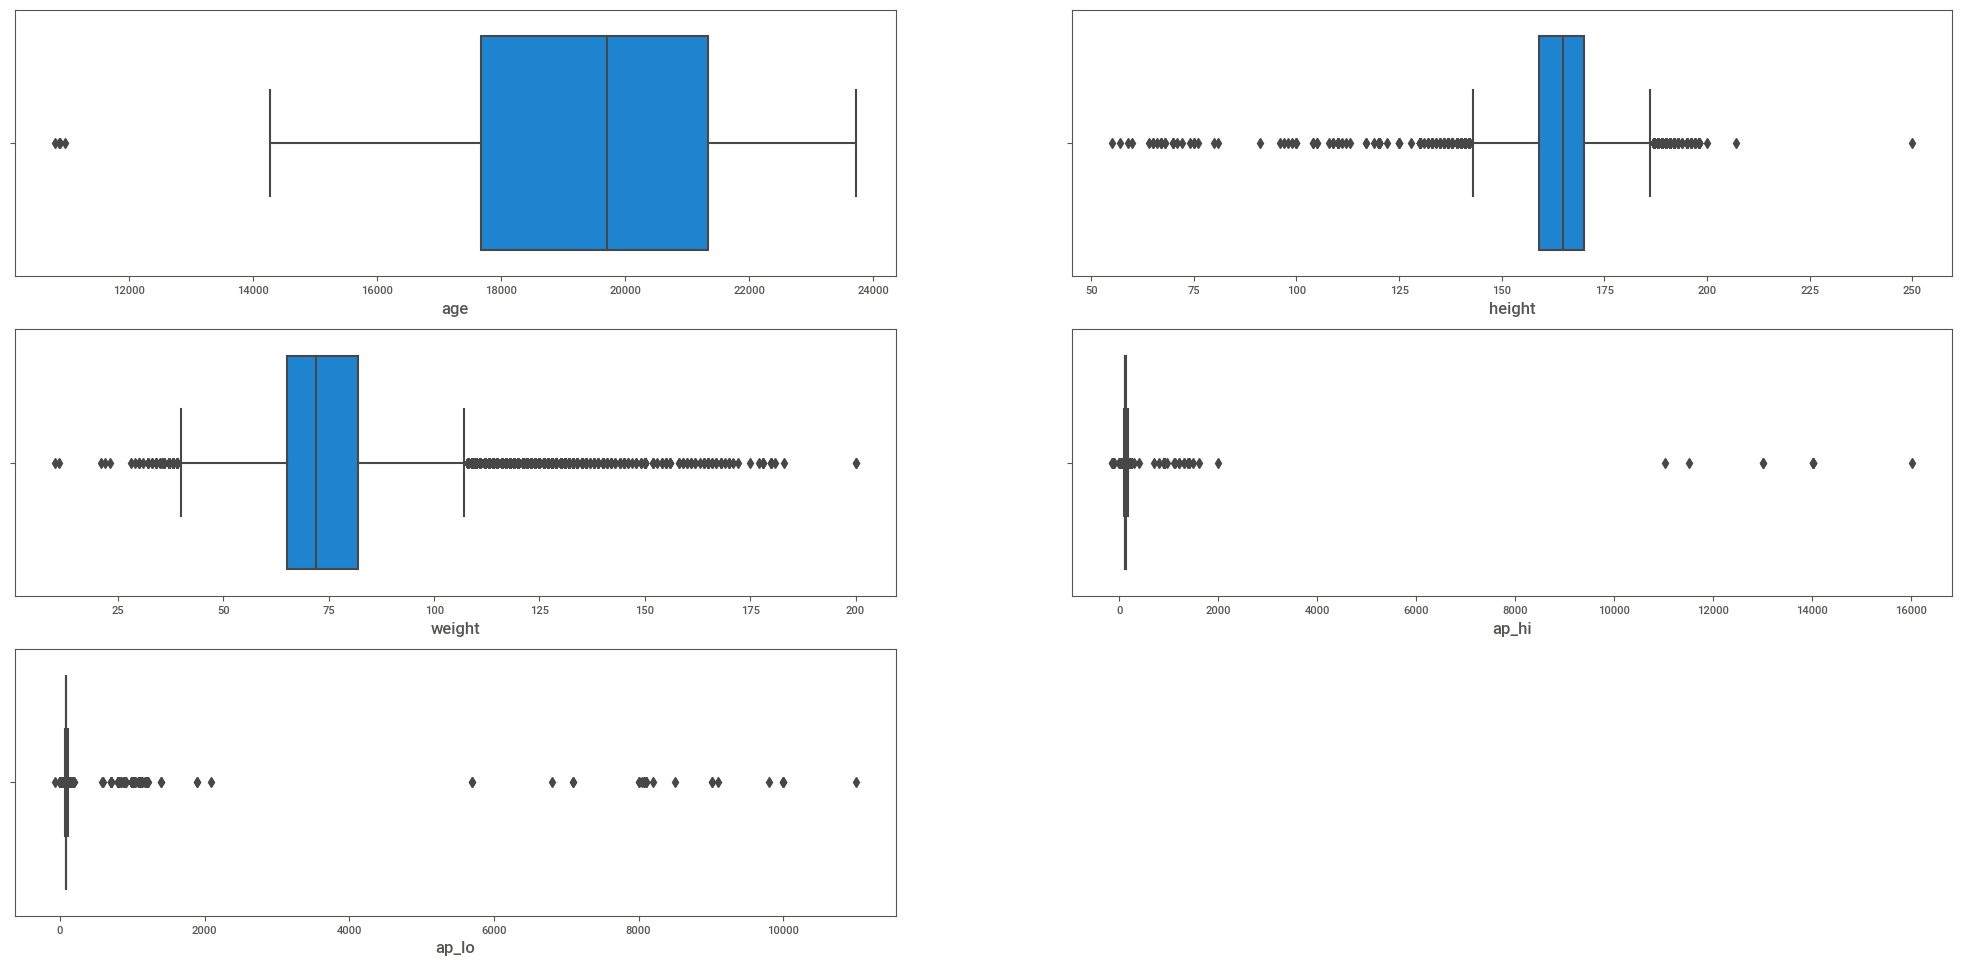

In [18]:
multiple_boxplots(num_attributes, 3, 2);

To-do: Outliers Study

#### 1.4.3 Categorical Attributes

In [19]:
df1_cat = df1.copy()

df1_cat = cat_convert(df1_cat)

cat_attributes = df1_cat[['gender', 'cholesterol', 'glucose', 'smoker', 'alcohol_intake', 'physical_activity', 'cardio', 'cardio_result']]
cat_attributes.head()

,gender,cholesterol,glucose,smoker,alcohol_intake,physical_activity,cardio,cardio_result
0,man,normal,normal,no,no,yes,0,no
1,woman,well above normal,normal,no,no,yes,1,yes
2,woman,well above normal,normal,no,no,no,1,yes
3,man,normal,normal,no,no,yes,1,yes
4,woman,normal,normal,no,no,no,0,no


In [20]:
categorical_metrics(cat_attributes, 'gender')

,absolute,percent %
woman,45530,65.043
man,24470,34.957


In [21]:
categorical_metrics(cat_attributes, 'cholesterol')

,absolute,percent %
normal,52385,74.836
above normal,9549,13.641
well above normal,8066,11.523


In [22]:
categorical_metrics(cat_attributes, 'glucose')

,absolute,percent %
normal,59479,84.970
well above normal,5331,7.616
above normal,5190,7.414


In [23]:
categorical_metrics(cat_attributes, 'smoker')

,absolute,percent %
no,63831,91.187
yes,6169,8.813


In [24]:
categorical_metrics(cat_attributes, 'alcohol_intake')

,absolute,percent %
no,66236,94.623
yes,3764,5.377


In [25]:
categorical_metrics(cat_attributes, 'physical_activity')

,absolute,percent %
yes,56261,80.373
no,13739,19.627


That info is strange, I believed that the percentage of people who exercised would be much lower

In [26]:
categorical_metrics(cat_attributes, 'cardio_result')

,absolute,percent %
no,35021,50.030
yes,34979,49.970


### 1.5 Save State

In [27]:
df1.to_pickle(homepath + 'data/processed/df1.pkl')

## 2. FEATURE ENGINEERING

### 2.1 Load Checkpoint

In [28]:
df2 = pd.read_pickle(homepath + 'data/processed/df1.pkl')

### 2.2 Age and Height Units

In [29]:
# Converting Age from days to years
df2['age'] = df2['age'].apply(lambda x: x / 365)
df2['age'] = df2['age'].astype(int)

# Converting Height from cm to m
df2['height'] = df2['height'].apply(lambda x: x / 100)

### 2.3 Blood Pressure

According to the American Heart Association, the ideal blood pressure range is 120/80 mm Hg. A person’s blood pressure is expressed in two values – 120 and 80 in the previous case. The first value is the systolic blood pressure, while the value after the slash ‘/’ symbol is the diastolic blood pressure.


- **Systolic blood pressure**: This unit indicates how much pressure blood exerts on the arterial walls when the heart beats at the time of measurement. This is when the heart pumps blood out of the heart and circulates it to various organs in the body.
- **Diastolic blood pressure**: This unit indicates how much pressure is exerted on the arterial walls when the heart rests between two beats. This is the period during which the heart opens its chamber to fill with blood.

In general, systolic blood pressure receives more medical attention. It is also an important risk factor for cardiovascular disease in older people. It is widely observed that systolic blood pressure increases steadily with age due to the increased stiffness of large arteries and plaque formation in the blood vessels.
Under normal circumstances, blood pressure approaching 300 is hazardous. In various health forums, individuals have reported having experienced blood pressure above 250. Most of these individuals have also reported suffering from extreme medical conditions, such as a heavy buzzing in the ears, uncontrollably intense headaches, dizziness, and even loss of consciousness.


[Reference](https://www.scienceabc.com/eyeopeners/how-high-can-a-blood-pressure-go.html)

A sudden fall in blood pressure can be dangerous. A change of just 20 mm Hg — a drop from 110 systolic to 90 mm Hg systolic, for example, can cause dizziness and fainting when the brain fails to receive enough blood. And big drops, such as those caused by uncontrolled bleeding, severe infections or allergic reactions, can be life-threatening.

[Reference](https://www.mayoclinic.org/diseases-conditions/low-blood-pressure/symptoms-causes/syc-20355465)

Blood pressure can be classified into four categories based on the readings from a sphygmomanometer:

- **Hypotension**: Systolic pressure reading lower than 90 and diastolic lower than 60;
- **Normal**: Systolic pressure reading between 90-120 and diastolic pressure reading between 60-80 is considered normal;
- **Pre-high blood pressure**: Systolic pressure reading between 120-140 and diastolic pressure reading between 80-90 is considered a slightly elevated level of blood pressure;
- **High blood pressure**: Systolic pressure reading between 140-180 and diastolic pressure reading between 90-100 is considered to be a high blood pressure condition;
- **Hypertensive crisis**: If one’s systolic pressure exceeds 180 or diastolic pressure crosses 100, it is a stage that requires immediate medical attention.

In [30]:
df2['blood_pressure'] = df2.apply(lambda x:  'hypothension' if (x['ap_hi'] < 90) and (x['ap_lo'] < 60)
                                        else 'normal' if (x['ap_hi'] >= 90 and x['ap_hi'] <= 120) and (x['ap_lo'] >= 60 and x['ap_lo'] <= 80)
                                        else 'prehigh_blood_pressure' if (x['ap_hi'] > 120 and x['ap_hi'] <= 140) or (x['ap_lo'] > 80 and x['ap_lo'] <= 90) 
                                        else 'high_blood_pressure' if (x['ap_hi'] > 140 and x['ap_hi'] <= 180) or (x['ap_lo'] > 90 and x['ap_lo'] <= 100)
                                        else 'hypertensive_crisis' if (x['ap_hi'] > 180) and (x['ap_lo'] > 100)
                                        else 'need_an_analysis', axis = 1)

In [31]:
categorical_metrics(df2, 'blood_pressure')

,absolute,percent %
normal,38750,55.357
prehigh_blood_pressure,24774,35.391
high_blood_pressure,5804,8.291
need_an_analysis,473,0.676
hypertensive_crisis,178,0.254
hypothension,21,0.030


### 2.4 Pulse Pressure

https://www.healthline.com/health/pulse-pressure#low-vs-normal-vs-high

In [32]:
df2['pulse_pressure_range'] = df2['ap_hi'] - df2['ap_lo']

df2['pulse_pressure'] = df2['pulse_pressure_range'].apply(lambda x: 'low' if (x >= 0) and (x < 40) 
                                                            else 'normal' if (x >= 40) and (x < 60)
                                                            else 'high' if (x >= 60)
                                                            else 'measurement_error')


In [33]:
categorical_metrics(df2, 'pulse_pressure')

,absolute,percent %
normal,50221,71.744
high,11382,16.260
low,7163,10.233
measurement_error,1234,1.763


### 2.5 BMI and Body Mass

In [34]:
# BMI
df2['bmi'] = round(df2['weight']/(df2['height']**2), 1)

df2['body_mass'] = df2['bmi'].apply(lambda x: 'underweight' if (x < 18.5)
                                        else  'normal' if (x >= 18.5) and (x < 25)
                                        else  'overweight' if (x >= 25) and (x < 30)
                                        else  'obese' if (x >= 30) and (x < 35)
                                        else 'extremely_obese')

In [35]:
categorical_metrics(df2, 'body_mass')

,absolute,percent %
overweight,25546,36.494
normal,25216,36.023
obese,12302,17.574
extremely_obese,6307,9.010
underweight,629,0.899


### 2.6 Period of Life

https://courses.lumenlearning.com/wm-lifespandevelopment/chapter/periods-of-human-development/#:~:text=Middle%20adulthood%20spans%20the%20years,referred%20to%20as%20middle%20adulthood.

In [36]:
age_min = df1['age'].min()
age_max = df1['age'].max()

print(f'The smallest age in this dataset is {age_min} years.\nThe highest age in this dataset is {age_max} years.')

The smallest age in this dataset is 10798 years.
The highest age in this dataset is 23713 years.


In [37]:
df2['period_of_life'] = df2['age'].apply(lambda x: 'early_adulthood' if (x >= 29) and (x < 40)
                                            else   'middle_adulthood')

In [38]:
categorical_metrics(df2, 'period_of_life')

,absolute,percent %
middle_adulthood,68216,97.451
early_adulthood,1784,2.549


### 2.7 Save State

In [39]:
df2.to_pickle(homepath + 'data/processed/df2.pkl')

## 3. DATA FILTERING

### 3.1 Load Checkpoint

In [40]:
df3 = pd.read_pickle(homepath + 'data/processed/df2.pkl')

### 3.2 `ap_hi` and `ap_lo`

In [41]:
len(df1[df1['ap_hi'] < 60])

188

In [42]:
len(df1[df1['ap_hi'] > 350])

39

In [43]:
len(df1[df1['ap_lo'] > 250])

953

In [44]:
len(df1[df1['ap_lo'] < 30])

53

Possible interpretations
1. Results with a negative value do not exist in the blood pressure measurement, probably the - was entered as a typing error;
2. Some results far superior to the highest and lowest blood pressure values ​​recorded in scrapbooks may be measurement errors;



In [45]:
# ap_hi
df1 = df1[df1['ap_hi'].between(60, 350)]

# ap_lo
df1 = df1[df1['ap_lo'].between(30, 250)]

### 3.3 After Filtering

In [46]:
rows_lost = 70000 - len(df1)
print(f'In the data filtering, {rows_lost} rows  have been removed')

In the data filtering, 1219 rows  have been removed


### 3.4 Save State

In [47]:
df3.to_pickle(homepath + 'data/processed/df3.pkl')

## 4. EXPLORATORY DATA ANALYSIS

### 4.1 Load Checkpoint

In [48]:
df4 = pd.read_pickle(homepath + 'data/processed/df3.pkl')

### 4.2 Save State

In [49]:
df4.to_pickle(homepath + 'data/processed/df4.pkl')

## 5. DATA PREPARATION

### 5.1 Load Checkpoint

In [50]:
df5 = pd.read_pickle(homepath + 'data/processed/df4.pkl')

### 5.2 Split Data

In [51]:
# Train -> 70%
# Test -> 20%
# Validation -> 10%
x_train, x_test = train_test_split(df5, test_size = 0.2, random_state = seed)

# if train = 80% x dataset, then val = 0.1/0.8 = 0.125
# 0.125 x 0.8 = 0.1
x_train, x_val = train_test_split(df5, test_size = 0.125, random_state = seed)

### 5.3 Encoding

In [52]:
# Ordinal Encoding
bp_encoding = {'need_an_analysis': 0, 'hypothension': 1, 'normal': 2, 'prehigh_blood_pressure': 3, 'high_blood_pressure': 4, 'hypertensive_crisis': 5}
pp_encoding = {'measurement_error': 0, 'low': 1, 'normal': 2, 'high': 3}
bm_encoding = {'underweight': 1, 'normal': 2, 'overweight': 3, 'obese': 4, 'extremely_obese': 5}
pl_encoding = {'early_adulthood': 1, 'middle_adulthood': 2}

# One Hot Encoding
x_train, x_test, x_val = [pd.get_dummies(dataframe, prefix = ['gender'], columns = ['gender']) for dataframe in [x_train, x_test, x_val]]



for df in [x_train, x_test, x_val]:
    df['blood_pressure'] = df['blood_pressure'].map(bp_encoding)
    df['pulse_pressure'] = df['pulse_pressure'].map(pp_encoding)
    df['body_mass'] = df['body_mass'].map(bm_encoding)
    df['period_of_life'] = df['period_of_life'].map(pl_encoding)

### 5.4 Rescaling

In [53]:
num_attributes = df5[['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi', 'pulse_pressure_range']]

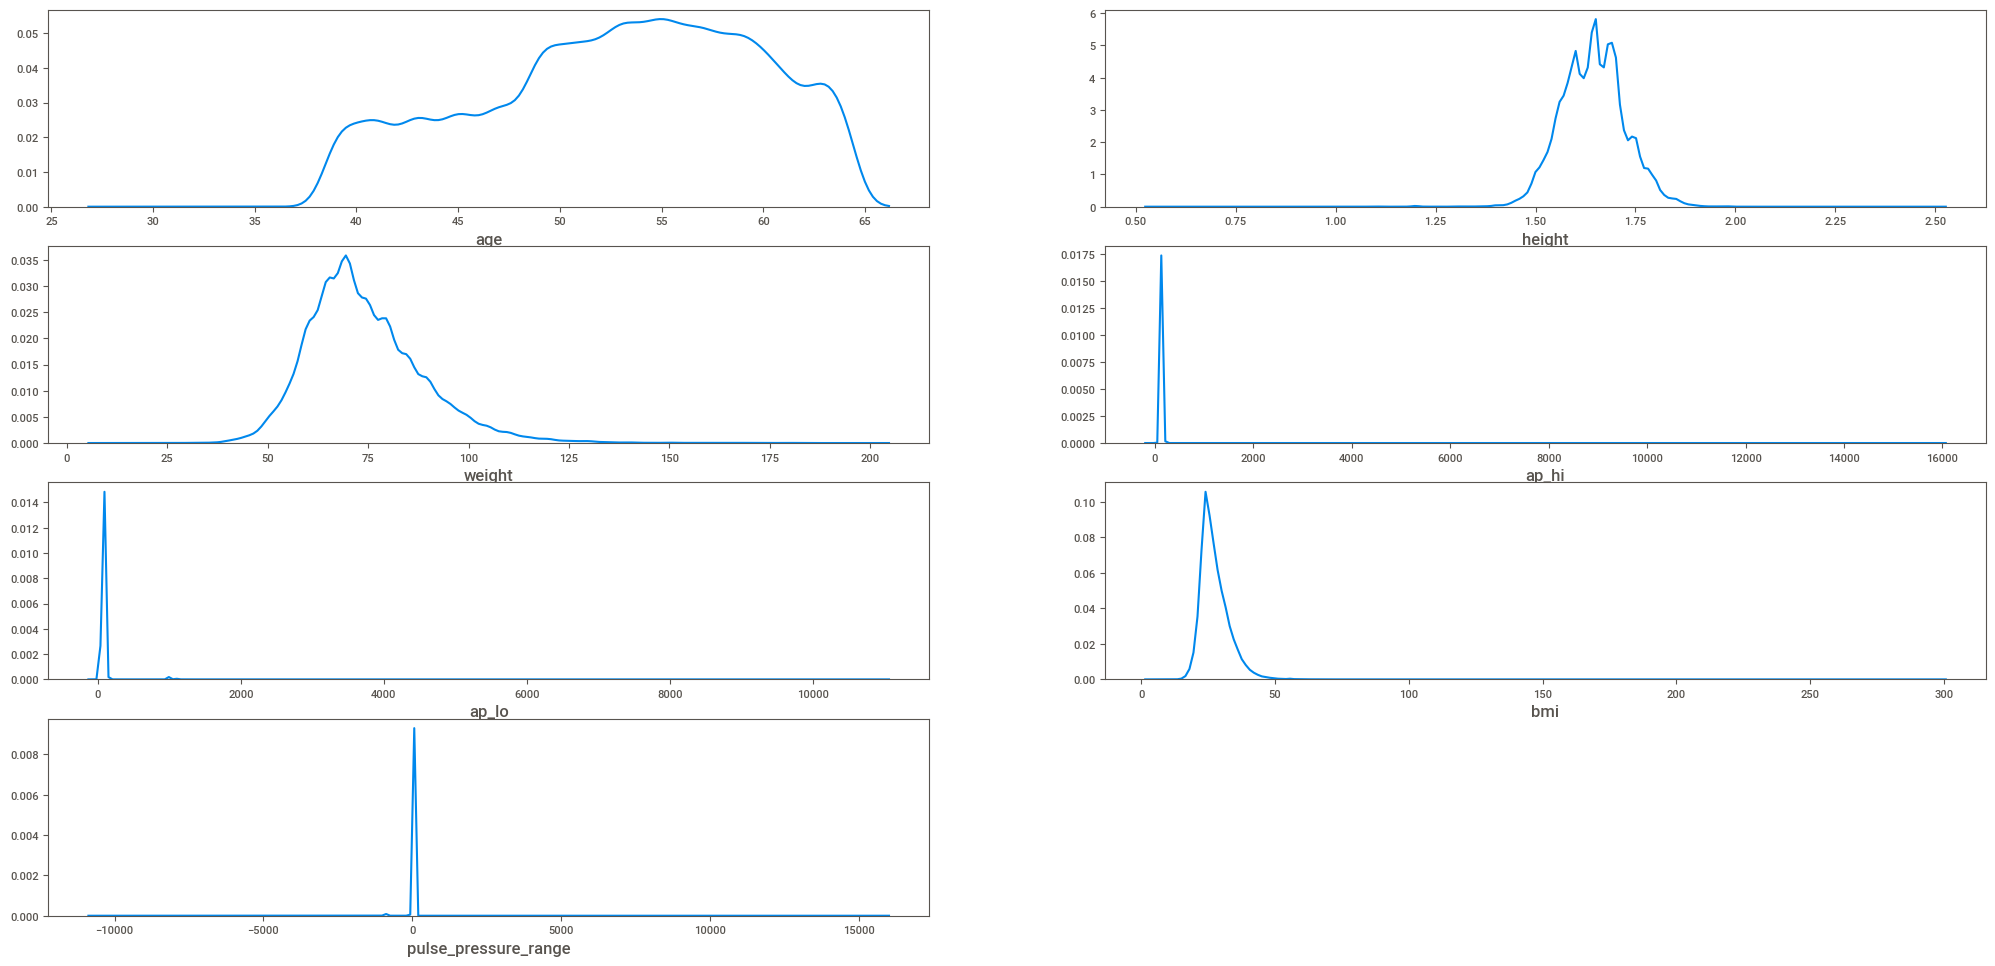

In [54]:
multiple_kdeplots(num_attributes, 4, 2);

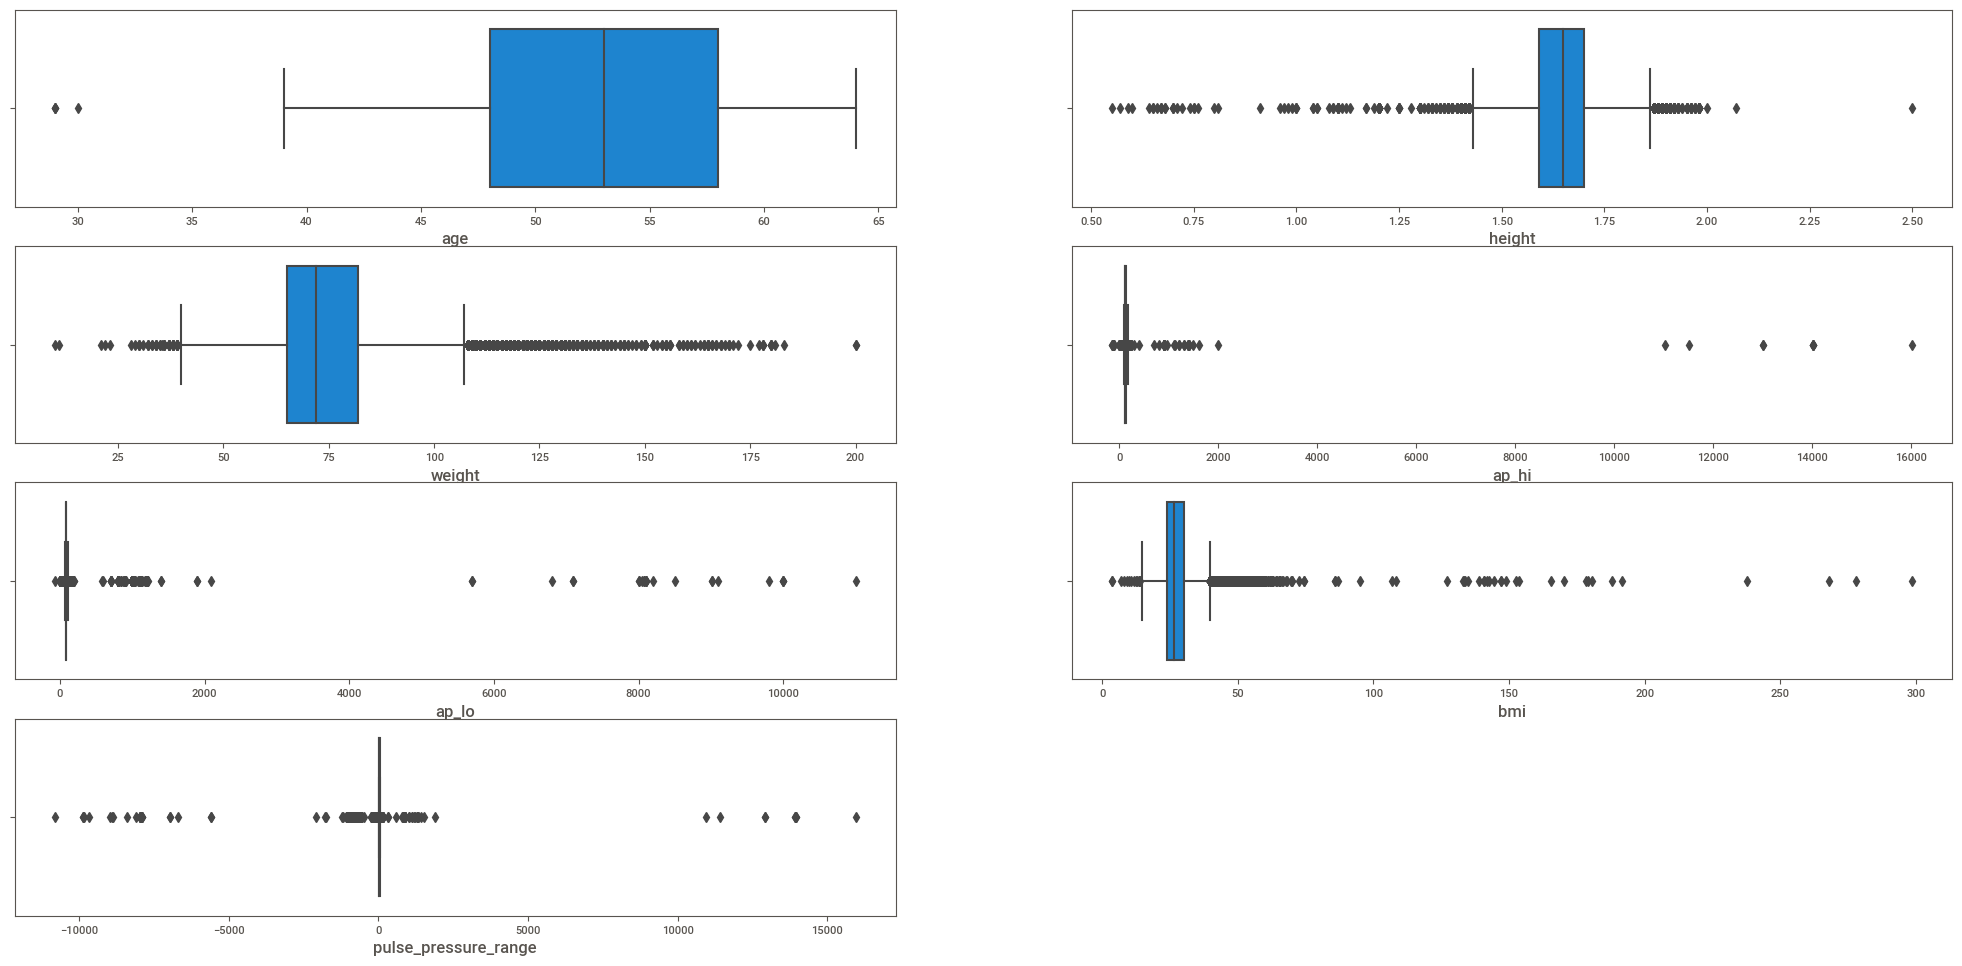

In [55]:
multiple_boxplots(num_attributes, 4, 2);

<p style="color:#FF0000">To-do:</p> 

-   Pulse range: Outliers 
-   bmi: Outliers at the right side
-   pressure: Outliers
-   height: Outliers at the left side

1. Without Outlier and With Normal Distribution: Standard Scaler (Mean and std deviation)
2. With Outliers and Normal Distribution: Robust Scaler (Quartile)
3. Without Normal Distribution: MinMax Scaler

In [56]:
# scaler
mms = MinMaxScaler()
rs = RobustScaler()

min_max_scaler = ['age', 'height', 'ap_hi', 'ap_lo', 'bmi']
robust_scaler = ['pulse_pressure_range', 'weight']

for col in min_max_scaler:
    pickle.dump(mms, open(homepath + f'src/features/{col}_scaler.pkl', 'wb'))
    for dataframe in [x_train, x_test, x_val]:
        dataframe[[col]] = mms.fit_transform(dataframe[[col]].values)

for col in robust_scaler:
    pickle.dump(rs, open(homepath + f'src/features/{col}_scaler.pkl', 'wb'))
    for dataframe in [x_train, x_test, x_val]:
        dataframe[[col]] = rs.fit_transform(dataframe[[col]].values)

### 5.5 Split X and y

In [57]:
# target: cardio
y_train, y_test, y_val = [dataframe['cardio'] for dataframe in [x_train, x_test, x_val]]
ids_train, ids_test, ids_val = [dataframe['id'] for dataframe in [x_train, x_test, x_val]]
X_train, X_test, X_val = [dataframe.drop(columns = ['cardio', 'id']) for dataframe in [x_train, x_test, x_val]]

### 5.6 Feature Importance

#### 5.6.1 Feature Importance with ExtraTrees

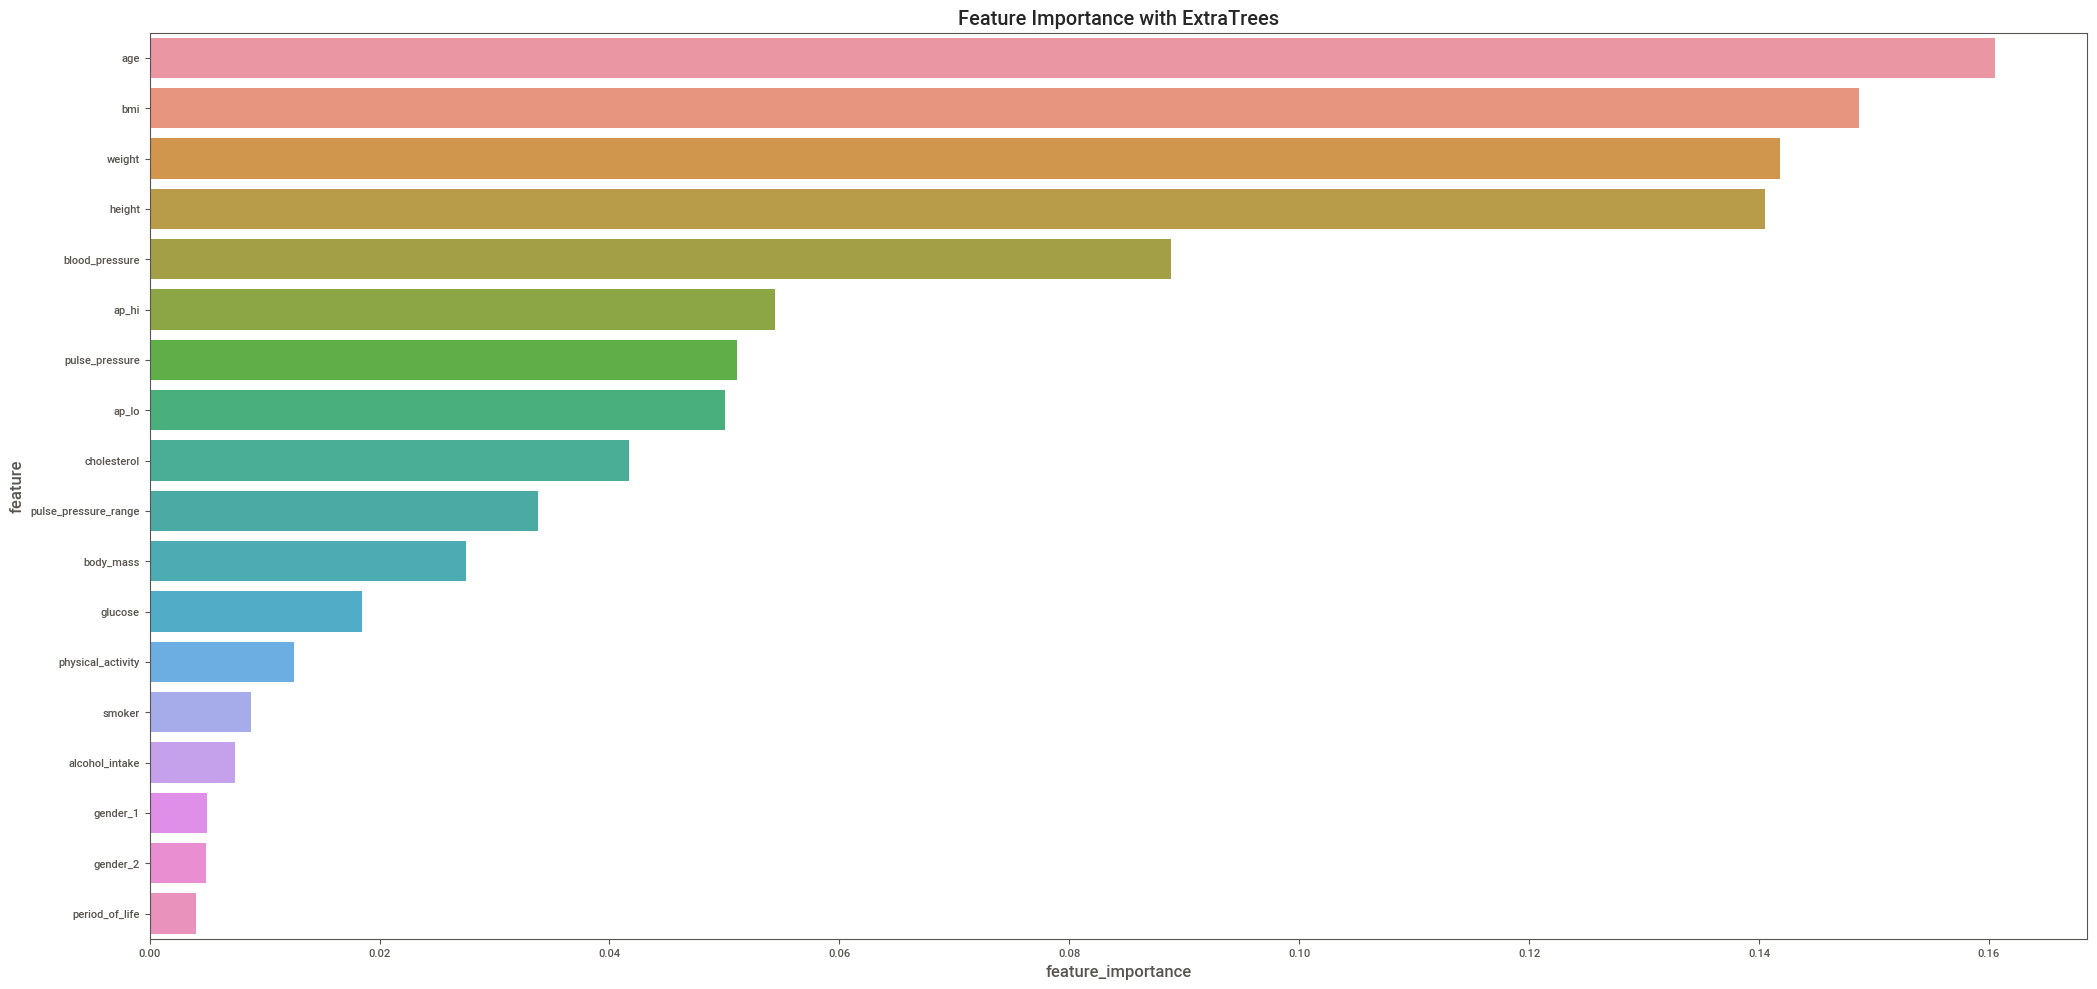

In [58]:
et_importance = ExtraTreesClassifier(n_estimators = 100, random_state = seed, n_jobs = 6)
et_importance.fit(X_train, y_train)

# feature importance dataframe
feature_selection = pd.DataFrame({'feature': X_train.columns,'feature_importance': et_importance.feature_importances_})\
                                .sort_values('feature_importance', ascending = False).reset_index(drop = True)

# plot feature importance
ax = sns.barplot(x = 'feature_importance', y = 'feature', data = feature_selection, orient = 'h')
ax.set_title('Feature Importance with ExtraTrees');

#### 5.6.2 Feature Importance with RandomForest

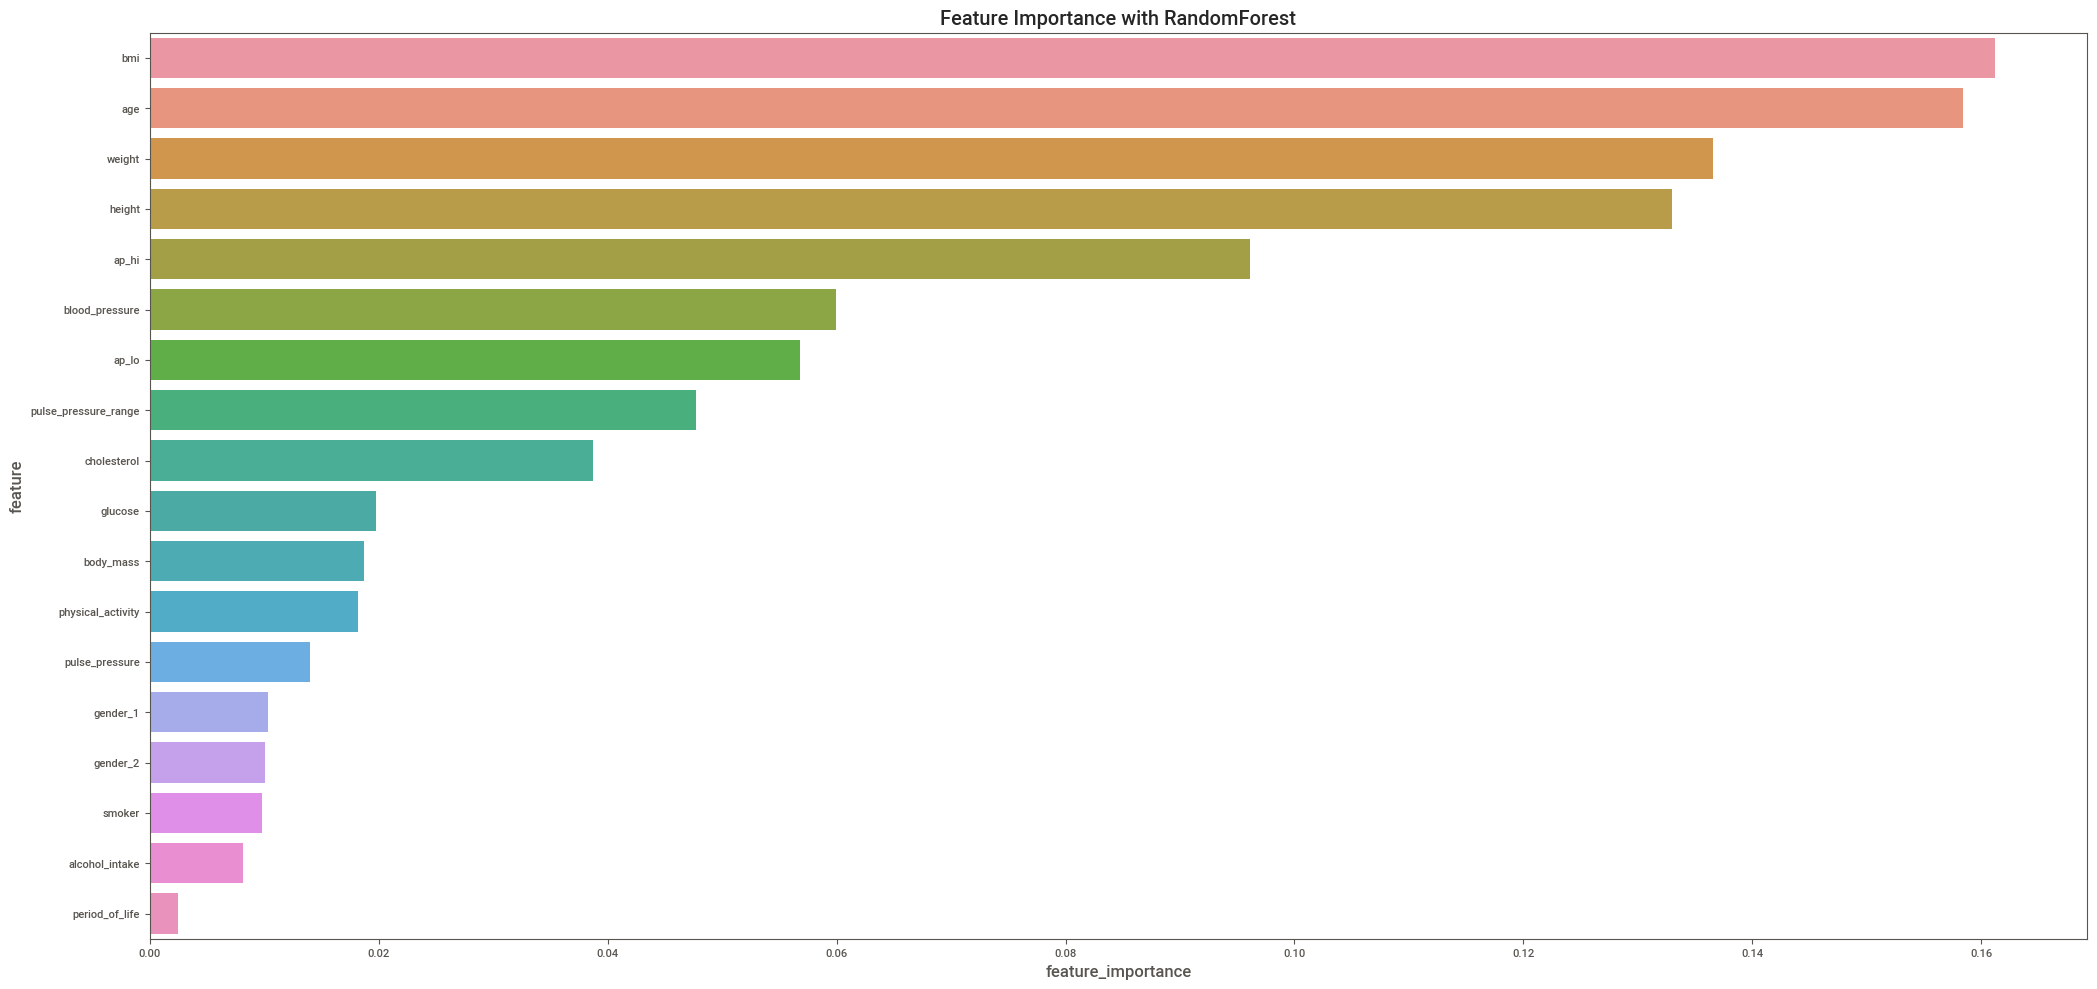

In [59]:
rf_importance = RandomForestClassifier(n_estimators = 100, random_state = seed, n_jobs = 6)
rf_importance.fit(X_train, y_train)

# feature importance dataframe
feature_selection = pd.DataFrame({'feature': X_train.columns,'feature_importance': rf_importance.feature_importances_})\
                                .sort_values('feature_importance', ascending = False).reset_index(drop = True)

# plot feature importance
ax = sns.barplot(x = 'feature_importance', y = 'feature', data = feature_selection, orient = 'h')
ax.set_title('Feature Importance with RandomForest');

#### 5.6.3 Rank Features

/home/gutto/Repos/Cardio-Catch-Diseases/.venv/lib/python3.9/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


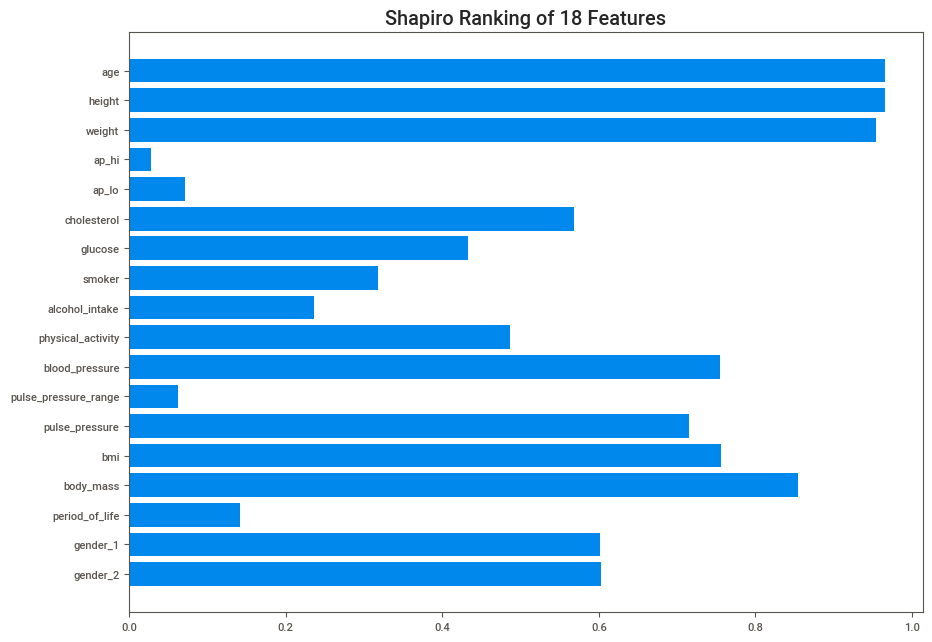

In [60]:
visualizer_1d = Rank1D(algorithm = 'shapiro', size = (1024, 768))
visualizer_1d.fit(X_train, y_train)           
visualizer_1d.transform(X_train)        
visualizer_1d.finalize();

<p style="color:#FF0000">To-do:</p> 

-   p-value alert

#### 5.6.4 Boruta

In [61]:
rf_boruta = RandomForestClassifier(n_estimators = 500, n_jobs = 6, random_state = seed)

boruta = BorutaPy(rf_boruta, n_estimators = 'auto', random_state = seed).fit(X_train.values, y_train.values)

In [62]:
cols_selected = boruta.support_.tolist()

cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()

cols_not_selected_boruta = list(np.setdiff1d(X_train.columns, cols_selected_boruta))

In [63]:
cols_selected_boruta

['age', 'ap_hi']

In [64]:
cols_not_selected_boruta

['alcohol_intake',
 'ap_lo',
 'blood_pressure',
 'bmi',
 'body_mass',
 'cholesterol',
 'gender_1',
 'gender_2',
 'glucose',
 'height',
 'period_of_life',
 'physical_activity',
 'pulse_pressure',
 'pulse_pressure_range',
 'smoker',
 'weight']

### 5. Save State

In [65]:
X_train.to_pickle(homepath + 'data/processed/X_train.pkl')
X_test.to_pickle(homepath + 'data/processed/X_test.pkl')
X_val.to_pickle(homepath + 'data/processed/X_val.pkl')
y_train.to_pickle(homepath + 'data/processed/y_train.pkl')
y_test.to_pickle(homepath + 'data/processed/y_test.pkl')
y_val.to_pickle(homepath + 'data/processed/y_val.pkl')
ids_train.to_pickle(homepath + 'data/processed/ids_train.pkl')
ids_test.to_pickle(homepath + 'data/processed/ids_test.pkl')
ids_val.to_pickle(homepath + 'data/processed/ids_val.pkl')

## 6. MACHINE LEARNING MODELLING

In [66]:
X_train = pd.read_pickle(homepath + 'data/processed/X_train.pkl')
X_val = pd.read_pickle(homepath + 'data/processed/X_val.pkl')
y_train = pd.read_pickle(homepath + 'data/processed/y_train.pkl')
y_val = pd.read_pickle(homepath + 'data/processed/y_val.pkl')

In [67]:
models = [
          RandomForestClassifier(random_state = seed, n_jobs = 7),
          ExtraTreesClassifier(random_state = seed, n_jobs = 7),
          GaussianNB(),
          XGBClassifier(random_state = seed, n_jobs = 7, eval_metric = 'logloss', use_label_encoder = False),
          CatBoostClassifier(random_state = seed, verbose = False),
          AdaBoostClassifier(random_state = seed),
          LGBMClassifier(random_state = seed, n_jobs = 7),
          KNeighborsClassifier(n_neighbors = 7, n_jobs = 7),
          GradientBoostingClassifier(random_state = seed)
         ]

In [85]:
metrics_result = metrics_df(models, 'cardio', X_train, y_train, X_val, y_val)

Please, wait a moment - Doing ML
Training model 1/9 -> RandomForestClassifier
Training model 2/9 -> ExtraTreesClassifier
Training model 3/9 -> GaussianNB
Training model 4/9 -> XGBClassifier
Training model 5/9 -> CatBoostClassifier
Training model 6/9 -> AdaBoostClassifier
Training model 7/9 -> LGBMClassifier
Training model 8/9 -> KNeighborsClassifier
Training model 9/9 -> GradientBoostingClassifier
Finished, check the results


In [86]:
metrics_result

,Model_Name,Accuracy,Precision,Recall,F1-Score,ROCAUC
0,RandomForestClassifier,0.627,0.629,0.623,0.626,0.627
0,ExtraTreesClassifier,0.706,0.713,0.692,0.702,0.706
0,GaussianNB,0.684,0.667,0.738,0.701,0.684
0,XGBClassifier,0.610,0.613,0.604,0.608,0.610
0,CatBoostClassifier,0.645,0.641,0.666,0.653,0.645
0,AdaBoostClassifier,0.503,0.826,0.013,0.026,0.505
0,LGBMClassifier,0.611,0.586,0.766,0.664,0.611
0,KNeighborsClassifier,0.704,0.717,0.676,0.696,0.704
0,GradientBoostingClassifier,0.601,0.799,0.272,0.406,0.602


In [90]:
cv_result = cross_validation(models, 'cardio', X_train, y_train)

Please, wait a moment, Doing CV
Folding model 1/9 -> RandomForestClassifier
Folding model 2/9 -> ExtraTreesClassifier
Folding model 3/9 -> GaussianNB
Folding model 4/9 -> XGBClassifier
Folding model 5/9 -> CatBoostClassifier
Folding model 6/9 -> AdaBoostClassifier
Folding model 7/9 -> LGBMClassifier
Folding model 8/9 -> KNeighborsClassifier
Folding model 9/9 -> GradientBoostingClassifier
Finished, check the results


In [91]:
cv_result

,Model_Name,Accuracy Mean,Accuracy STD,Precision Mean,Precision STD,Recall Mean,Recall STD,F1 Score Mean,F1 Score STD,ROCAUC Mean,ROCAUC STD
0,RandomForestClassifier,0.708,0.002,0.711,0.004,0.700,0.003,0.706,0.003,0.708,0.002
0,ExtraTreesClassifier,0.702,0.007,0.704,0.008,0.696,0.006,0.700,0.007,0.702,0.007
0,GaussianNB,0.691,0.016,0.719,0.024,0.635,0.088,0.669,0.045,0.691,0.016
0,XGBClassifier,0.702,0.022,0.727,0.025,0.650,0.080,0.682,0.045,0.702,0.023
0,CatBoostClassifier,0.708,0.024,0.733,0.025,0.659,0.074,0.691,0.044,0.708,0.024
0,AdaBoostClassifier,0.712,0.024,0.738,0.026,0.659,0.068,0.694,0.040,0.712,0.024
0,LGBMClassifier,0.715,0.023,0.741,0.025,0.664,0.064,0.698,0.039,0.715,0.023
0,KNeighborsClassifier,0.713,0.023,0.735,0.028,0.668,0.061,0.697,0.036,0.713,0.023
0,GradientBoostingClassifier,0.715,0.023,0.737,0.027,0.671,0.058,0.701,0.035,0.715,0.023


## 7. HYPERPARAMETER FINE TUNNING


## 8. BUSINESS TRANSLATION
